In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.2 MB 2.5 MB/s 


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2


## Setup

In [ ]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline   
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.2


## Hardware Config

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on GPU
N_REPLICAS: 1


## Prepare the data

In [ ]:
# load data
vcf_file = '[path]/HLA_recode_chr_pos.vcf'

# load genotype
genotypes = pd.read_csv(vcf_file, sep='\t', index_col=0).iloc[:, :-1]

headers = genotypes.columns[:]
genotypes.head()

,6_33500639,6_33500853,6_33500930,6_33501330,6_33501648,6_33501844,6_33503018,6_33503323,6_33503878,6_33504462,...,6_36591755,6_36596648,6_36596784,6_36597695,6_36597907,6_36598178,6_36598209,6_36598837,6_36599010,6_36599596
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,1|0,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,0|1,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1
HG00099,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|1,1|1,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1
HG00100,0|0,0|1,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|0,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1
HG00101,0|0,1|1,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,1|0,1|0,1|0,1|0,1|0,0|0,1|0,1|0,1|0,1|0


In [ ]:
ped_file = '[path]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [ ]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [ ]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 7160)

In [ ]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 7160)

### MAF

In [ ]:
def freq_mapper(g):
  return 0 if g == 0 else 1 if g==1 or g==2 else 2

def maf_mapper(g):
  return min(g, 1-g)

In [ ]:
_X = X.applymap(freq_mapper)
_X = _X.sum(axis=0)/(2*X.shape[0])
_X

6_33500639    0.072484
6_33500853    0.507388
6_33500930    0.098243
6_33501330    0.075479
6_33501648    0.098243
                ...   
6_36598178    0.052915
6_36598209    0.211462
6_36598837    0.224840
6_36599010    0.480032
6_36599596    0.221446
Length: 7160, dtype: float64

In [ ]:
mafs = _X.map(maf_mapper)
mafs

6_33500639    0.072484
6_33500853    0.492612
6_33500930    0.098243
6_33501330    0.075479
6_33501648    0.098243
                ...   
6_36598178    0.052915
6_36598209    0.211462
6_36598837    0.224840
6_36599010    0.480032
6_36599596    0.221446
Length: 7160, dtype: float64

(array([1762., 1946., 1297.,  917., 1238.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <a list of 5 Patch objects>)

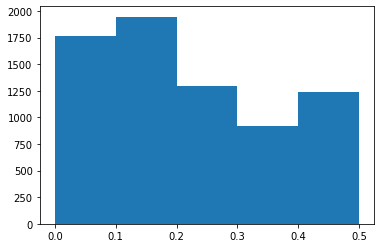

In [ ]:
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5])

In [ ]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([1762, 1946, 1297,  917, 1238]))

In [ ]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 5
# optimizer learning rate
learning_rate = 0.0001
epochs = 60 
#epochs = 100   # chr20 LOS 5K


# training batch size
#batch_size = 32   # u19, 4984 samples
bs = 32




# l1 regulalization
kr = 1e-5
k_initial = 'glorot_uniform'


# channel = inChannel
channel = inChannel

ndf_num = 128
kernel_len = 32
num_latent = ndf_num*4
p_size = 2



#dr_rate = drop_prec
dr_rate = 0.2  # avoid overfitting for missing ratio of 0.7

## Model

In [ ]:
# AE model in one cell
# # V1: verify our own ae model with yeast genotype data

# # 2.2.8 build variatial autoencoder for snp with subclassing function. 

class SNP_ENCODER(tf.keras.Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):    
        super(SNP_ENCODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate

        # object, can be saved in tf mode
        self.stride=1
        self.kl = kernel_len

        
    def build(self, inputs): 
        #encoder
        # dense layer 1
        self.c1 = layers.Conv1D(filters=self.ndf, kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr), 
                      input_shape=(self.feature_size, self.channel))
        self.p1 = layers.MaxPooling1D(pool_size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)
        self.bn1 = layers.BatchNormalization()
        
        # dense layer 2
        self.c2 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p2 = layers.MaxPooling1D(pool_size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)
        self.bn2 = layers.BatchNormalization()
        
        # dense layer 3
        self.c3 = layers.Conv1D(filters=(4*self.ndf), kernel_size=self.kl, strides=1, padding="same", 
                      activation='relu', use_bias=True, kernel_initializer=k_initial, 
                      kernel_regularizer=tf.keras.regularizers.L1(kr))
        self.p3 = layers.MaxPooling1D(pool_size=p_size)
        self.drop3 = layers.Dropout(rate=self.dr)

        super(SNP_ENCODER, self).build(inputs)
    
    def call(self, inputs, training=True):
        #print('SNP_ENCODER training flag: ', training)
        x = self.c1(inputs)
        x = self.bn1(x)
        x = self.p1(x)
        x = self.drop1(x, training=training)

        x = self.c2(x)
        x = self.bn2(x)
        x = self.p2(x)
        x = self.drop2(x, training=training)
        
        x = self.c3(x)
        return x

    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    
    
    
# SNP_DECODER(keras.Model):   
class SNP_DECODER(tf.keras.Model):     
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, kernel_len=kernel_len, n_latent=num_latent, dr=dr_rate):
        super(SNP_DECODER, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate
        
        # object, can be saved in tf mode
        self.stride=1
        self.kl=kernel_len
        
    def build(self, inputs):
        #decoder        
        self.c1 = layers.Conv1D(filters=(2*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr),
                      input_shape=((self.feature_size>>2), self.n_latent))
        
        self.bn1 = layers.BatchNormalization()
        self.s1 = layers.UpSampling1D(size=p_size)
        self.drop1 = layers.Dropout(rate=self.dr)
        
        # dense layer 2
        self.c2 = layers.Conv1D(filters=(1*self.ndf), kernel_size=self.kl, strides=self.stride, padding="same", 
                      activation='relu', use_bias=True, 
                      kernel_initializer=k_initial, kernel_regularizer=tf.keras.regularizers.L1(kr))

        self.bn2 = layers.BatchNormalization()
        self.s2 = layers.UpSampling1D(size=p_size)
        self.drop2 = layers.Dropout(rate=self.dr)
        

        # dense layer6
        self.c3 = layers.Conv1D(filters=self.channel, kernel_size=self.kl, strides=1, padding="same", 
                      activation='softmax', use_bias=True)
        
        super(SNP_DECODER, self).build(inputs)
        
    def call(self, inputs, training = True):
        #print('SNP_DECODER training flag: ', training)
        x = self.c1(inputs)
        x = self.bn1(x)
        x = self.s1(x)
        x = self.drop1(x, training=training)
        
        x = self.c2(x)
        x = self.bn2(x)
        x = self.s2(x)
        x = self.drop2(x, training=training)

        
        d_out = self.c3(x)
        return d_out
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size>>2, self.n_latent))
        
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    

    
#class SNP_AE(keras.Model):
class SNP_AE(tf.keras.Model):    
    def __init__(self, feature_size, channel=channel, ndf=ndf_num, n_latent=num_latent, dr=dr_rate):    
        super(SNP_AE, self).__init__()
        self.feature_size = feature_size
        self.channel = channel
        self.ndf = ndf
        self.n_latent = n_latent
        self.dr = dr # dropout rate      
        
        self.encoder = SNP_ENCODER(self.feature_size)
        self.decoder = SNP_DECODER(self.feature_size)
    

    def call(self, x, training=True): 
        latent = self.encoder(x, training)     
        res = self.decoder(latent, training)

        return res, latent
    
    
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = layers.Input(shape=(self.feature_size, self.channel))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))
    

In [ ]:
# plot snp vae encoder model

SNP_encoder = SNP_ENCODER(feature_size)
SNP_encoder.build((None, feature_size, channel))
SNP_encoder.build_graph().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7160, 5)]         0         
                                                                 
 conv1d_6 (Conv1D)           (None, 7160, 128)         20608     
                                                                 
 batch_normalization_4 (Batc  (None, 7160, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3580, 128)        0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 3580, 128)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 3580, 256)         104883

In [ ]:
# plot snp vae decoder model

SNP_decoder = SNP_DECODER(feature_size)

SNP_decoder.build((None, feature_size>>2, num_latent))
SNP_decoder.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1790, 512)]       0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1790, 256)         4194560   
                                                                 
 batch_normalization_6 (Batc  (None, 1790, 256)        1024      
 hNormalization)                                                 
                                                                 
 up_sampling1d_2 (UpSampling  (None, 3580, 256)        0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 3580, 256)         0         
                                                                 
 conv1d_10 (Conv1D)          (None, 3580, 128)         1048

In [ ]:
# plot snp vae model

SNP_ae = SNP_AE(feature_size)
SNP_ae.build((None, feature_size, channel))
SNP_ae.build_graph().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7160, 5)]         0         
                                                                 
 snp_encoder_2 (SNP_ENCODER)  (None, 1790, 512)        5265792   
                                                                 
 snp_decoder_2 (SNP_DECODER)  (None, 7160, 5)          5265285   
                                                                 
Total params: 10,531,077
Trainable params: 10,529,541
Non-trainable params: 1,536
_________________________________________________________________


In [ ]:
# AE model sub-functions

def generate_fake_missing(x_in, missing_ratio=0.5):

        # Generates missing genotypes
        # different missing loci for each individuals
        x_fake = x_in.copy()   # with .copy() to not overwrite the original data
        
        for i in range(x_in.shape[0]):
            missing_size = int(missing_ratio * x_in.shape[1])
          
            # without repeat random numbers: set replace with false
            missing_index = np.random.choice(x_in.shape[1], size=missing_size, replace=False)
            
            # missing loci are encoded as [0, 0]
            # x_fake[i, missing_index, :] = [0, 0, 1]  # yeast
            x_fake[i, missing_index, :] = [0, 0, 0, 0, 1]  # human

        return x_fake
        #return x_fake, x_in
    
    

def loss_function_cce(recon_x, x):
    # orders: y_true, y_pred
    cce = tf.keras.losses.categorical_crossentropy(x, recon_x)

    #cce = np.double(cce)
    cce = K.cast(cce, dtype='float32')

    lamb1 = 1.0
    loss = lamb1*cce
    #print('loss:', loss)
    
    loss = tf.reduce_mean(loss)
    #print('ave loss:', loss)
    
    return loss


## Training

In [ ]:
# With constraint
N_SPLITS=3
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = tf.keras.utils.to_categorical(X[X.index.isin(Y_train.index)].to_numpy(), inChannel)
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  
  accuracies = []
  print(f"Training using fold {fold}")
  print("*******************************************")
  print("*******************************************")
  
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True,
                                      stratify=y_train)
  
  
  for missing_ratio in [
                        0.01,
                        0.05,
                        0.1,
                        0.2
                        ]:
    train_X = np.copy(x_train)
    valid_X = np.copy(x_valid)

    best_val_acc = 0
    best_model_weights = None
    best_epoch = 0

    print(f"Missing rate {missing_ratio}")
    print("=====================================================")
    train_X_fake = generate_fake_missing(train_X, missing_ratio)

    diff = np.absolute(np.array(train_X) - np.array(train_X_fake))
    print('train_X_fake diff:', np.sum(diff))


    valid_X_fake = generate_fake_missing(valid_X, missing_ratio)
    diff = np.absolute(np.array(valid_X) - np.array(valid_X_fake))
    print('valid_X_fake diff:', np.sum(diff))


    K.clear_session()
    with strategy.scope():
      model = SNP_AE(feature_size)
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      train_loss_metric = tf.keras.metrics.CategoricalCrossentropy()
      val_loss_metric = tf.keras.metrics.CategoricalCrossentropy()

      train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
      val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

      for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        #----shuffle train data and lablel for each epoch-----------------------------------------------------------------------------------#    
        # shuffle data and labels at the same time
        idx = train_X.shape[0]


        indices = tf.range(start=0, limit=idx, dtype=tf.int32)

        shuffled_indices = tf.random.shuffle(indices)  
      
        train_X_fake = tf.gather(train_X_fake, shuffled_indices)
        train_X = tf.gather(train_X, shuffled_indices)        
        
        snp_x = tf.data.Dataset.from_tensor_slices(train_X_fake).batch(bs, drop_remainder=True) 
        snp_y = tf.data.Dataset.from_tensor_slices(train_X).batch(bs, drop_remainder=True)

        snp_x_v = tf.data.Dataset.from_tensor_slices(valid_X_fake).batch(bs, drop_remainder=True)
        snp_y_v = tf.data.Dataset.from_tensor_slices(valid_X).batch(bs, drop_remainder=True)

        loss_batch = []

        # Iterate over the batches of the dataset.
        for step, (snp_fake_batch, snp_label_batch) in tqdm(enumerate(zip(snp_x, snp_y))): 
          with tf.GradientTape() as tape:
              recon_inputs, latents= model(snp_fake_batch, training=True)
              loss = loss_function_cce(recon_inputs, snp_label_batch)


          grads = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))    

          loss_batch.append(loss.numpy())


          # Update training metric.
          train_acc_metric.update_state(snp_label_batch, recon_inputs)
          train_loss_metric.update_state(snp_label_batch, recon_inputs)


        # Display metrics at the end of each epoch.
        train_loss = train_loss_metric.result()
        print("Training loss over epoch: ", epoch, train_loss.numpy())

        train_acc = train_acc_metric.result()
        print("Training acc over epoch: ", epoch, train_acc.numpy())


        # Reset training metrics at the end of each epoch
        train_loss_metric.reset_states()
        train_acc_metric.reset_states()


        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in zip(snp_x_v, snp_y_v):   

            val_recons, latents = model(x_batch_val, training=False)
            # Update val metrics
            val_loss_metric.update_state(y_batch_val, val_recons)
            val_acc_metric.update_state(y_batch_val, val_recons)

        val_loss = val_loss_metric.result()
        val_acc = val_acc_metric.result()

        val_loss_metric.reset_states()
        val_acc_metric.reset_states()
        #print("Validation acc: %.4f" % (float(val_acc),))
        print("Validation loss: ", epoch, val_loss.numpy())
        print("Validation acc: ", epoch, val_acc.numpy())

        if best_val_acc < val_acc.numpy():
          best_val_acc = val_acc.numpy()
          best_model_weights = model.weights
          best_epoch = epoch


        #print('epoch %s: batch loss = %s' % (epoch, loss_batch))
        loss_epoch = np.mean(loss_batch)    
        print('epoch %s: loss = %s' % (epoch, loss_epoch))  

    print(f"Restoring best weights from epoch {best_epoch} with validation accuracy of {best_val_acc}")  
    model.set_weights(best_model_weights)
    
    save_name = f"[path]/HLA/maf/AE/AE_preds_mixed_mr_{missing_ratio}_fold_{fold}_.csv"
    avg_accuracy = []
    preds = []
    true_labels = []
    
    to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.copy(test_dataset[0])
    # test_X_missing = to_categorical(test_X_missing, 3)
    for i in tqdm(list(range(test_dataset[0].shape[0]))):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_ratio,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i:i+1, missing_index, :] = [0, 0, 0, 0, 1]
      # mMask = np.tile(attention_mask, (1, 1, 1))
      # predict
      predict_onehot, _ = model(test_X_missing[i:i+1, :, :], training=False)
      predict_onehot = predict_onehot.numpy()
      # predict_onehot = model.predict(test_X_missing[i:i+1, :, :])
      # predict_onehot = model.predict([test_X_missing[i:i + 1, :, :], mMask])
      # only care the missing position
      predict_missing_onehot = predict_onehot[0:1, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      
      preds.extend(predict_missing.ravel().tolist())
      
      predict_haplotypes = np.argmax(predict_onehot, axis=2)
      # Only for haploids
      # to_save_array[i] = np.where(predict_haplotypes==0, -1, 1)
      to_save_array[i] = predict_haplotypes
      # real label
      label_missing_onehot = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      # label_missing = np.argmax(label_missing_onehot, axis=2)
      label_missing = np.argmax(test_dataset[0][i:i + 1, missing_index], axis=2)
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing, label_missing)
      accuracy = np.mean(correct_prediction)
      # print('{}/{}, accuracy: {:.4f}'.format(
      #     i, test_X_missing.shape[0], accuracy))

      avg_accuracy.append(accuracy)

    df = pd.DataFrame(to_save_array, columns= headers[:], index = test_index)
    df.to_csv(save_name)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_ratio, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
        
    

Training using fold 1
*******************************************
*******************************************
Missing rate 0.01
train_X_fake diff: 213284.0
valid_X_fake diff: 23714.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 0.9727058
Training acc over epoch:  0 0.7052955
Validation loss:  0 1.4360641
Validation acc:  0 0.5507795
epoch 0: loss = 0.97270584
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.6085307
Training acc over epoch:  1 0.7953427
Validation loss:  1 2.0855496
Validation acc:  1 0.5507795
epoch 1: loss = 0.60853064
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.42239112
Training acc over epoch:  2 0.8528119
Validation loss:  2 2.7877214
Validation acc:  2 0.5507795
epoch 2: loss = 0.42239118
Start of epoch 3


46it [00:37,  1.22it/s]


Training loss over epoch:  3 0.29853302
Training acc over epoch:  3 0.8962463
Validation loss:  3 3.602456
Validation acc:  3 0.5507795
epoch 3: loss = 0.298533
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.22595187
Training acc over epoch:  4 0.92245835
Validation loss:  4 4.1767435
Validation acc:  4 0.5507795
epoch 4: loss = 0.22595187
Start of epoch 5


46it [00:37,  1.21it/s]


Training loss over epoch:  5 0.17891583
Training acc over epoch:  5 0.94000185
Validation loss:  5 4.617137
Validation acc:  5 0.5507795
epoch 5: loss = 0.17891581
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.14684312
Training acc over epoch:  6 0.9517698
Validation loss:  6 4.476049
Validation acc:  6 0.5507795
epoch 6: loss = 0.14684314
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.123222604
Training acc over epoch:  7 0.9602723
Validation loss:  7 3.075636
Validation acc:  7 0.55507946
epoch 7: loss = 0.12322259
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.10667723
Training acc over epoch:  8 0.96610475
Validation loss:  8 0.9913842
Validation acc:  8 0.71107715
epoch 8: loss = 0.10667724
Start of epoch 9


46it [00:37,  1.21it/s]


Training loss over epoch:  9 0.093952365
Training acc over epoch:  9 0.9704926
Validation loss:  9 0.19668755
Validation acc:  9 0.93140453
epoch 9: loss = 0.093952365
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.08333507
Training acc over epoch:  10 0.9741918
Validation loss:  10 0.07826851
Validation acc:  10 0.97736907
epoch 10: loss = 0.08333506
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.07539507
Training acc over epoch:  11 0.9768629
Validation loss:  11 0.04433328
Validation acc:  11 0.98938984
epoch 11: loss = 0.07539507
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.068679
Training acc over epoch:  12 0.9791034
Validation loss:  12 0.03034105
Validation acc:  12 0.9930988
epoch 12: loss = 0.068679
Start of epoch 13


46it [00:37,  1.21it/s]


Training loss over epoch:  13 0.06325616
Training acc over epoch:  13 0.98087543
Validation loss:  13 0.026561111
Validation acc:  13 0.99388003
epoch 13: loss = 0.06325617
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.058505334
Training acc over epoch:  14 0.9823585
Validation loss:  14 0.023428887
Validation acc:  14 0.9941987
epoch 14: loss = 0.058505327
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.054460324
Training acc over epoch:  15 0.98369914
Validation loss:  15 0.019557523
Validation acc:  15 0.9951973
epoch 15: loss = 0.054460324
Start of epoch 16


46it [00:37,  1.22it/s]


Training loss over epoch:  16 0.051088084
Training acc over epoch:  16 0.9847426
Validation loss:  16 0.020832222
Validation acc:  16 0.9947181
epoch 16: loss = 0.05108809
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.047747202
Training acc over epoch:  17 0.98579574
Validation loss:  17 0.016684078
Validation acc:  17 0.99568874
epoch 17: loss = 0.047747213
Start of epoch 18


46it [00:37,  1.21it/s]


Training loss over epoch:  18 0.044805173
Training acc over epoch:  18 0.9867408
Validation loss:  18 0.016017975
Validation acc:  18 0.99581707
epoch 18: loss = 0.044805173
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.04222284
Training acc over epoch:  19 0.98752445
Validation loss:  19 0.014943285
Validation acc:  19 0.9962177
epoch 19: loss = 0.04222284
Start of epoch 20


46it [00:37,  1.22it/s]


Training loss over epoch:  20 0.039955076
Training acc over epoch:  20 0.9882133
Validation loss:  20 0.0142746465
Validation acc:  20 0.99622554
epoch 20: loss = 0.03995507
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.037832666
Training acc over epoch:  21 0.98886174
Validation loss:  21 0.013337046
Validation acc:  21 0.9964176
epoch 21: loss = 0.037832666
Start of epoch 22


46it [00:37,  1.22it/s]


Training loss over epoch:  22 0.036374692
Training acc over epoch:  22 0.98929256
Validation loss:  22 0.012398735
Validation acc:  22 0.9965869
epoch 22: loss = 0.0363747
Start of epoch 23


46it [00:37,  1.21it/s]


Training loss over epoch:  23 0.03454479
Training acc over epoch:  23 0.9898541
Validation loss:  23 0.012646517
Validation acc:  23 0.9966594
epoch 23: loss = 0.034544785
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.03277885
Training acc over epoch:  24 0.9903993
Validation loss:  24 0.011192519
Validation acc:  24 0.99689156
epoch 24: loss = 0.032778848
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.03143776
Training acc over epoch:  25 0.9907825
Validation loss:  25 0.011240623
Validation acc:  25 0.9969457
epoch 25: loss = 0.031437762
Start of epoch 26


46it [00:37,  1.22it/s]


Training loss over epoch:  26 0.03035897
Training acc over epoch:  26 0.9911047
Validation loss:  26 0.01051886
Validation acc:  26 0.9969928
epoch 26: loss = 0.03035897
Start of epoch 27


46it [00:37,  1.22it/s]


Training loss over epoch:  27 0.028970828
Training acc over epoch:  27 0.9915293
Validation loss:  27 0.010780521
Validation acc:  27 0.9969387
epoch 27: loss = 0.028970825
Start of epoch 28


46it [00:37,  1.21it/s]


Training loss over epoch:  28 0.027958617
Training acc over epoch:  28 0.9917941
Validation loss:  28 0.009716589
Validation acc:  28 0.9971875
epoch 28: loss = 0.027958618
Start of epoch 29


46it [00:37,  1.22it/s]


Training loss over epoch:  29 0.026834577
Training acc over epoch:  29 0.99214715
Validation loss:  29 0.00986397
Validation acc:  29 0.99719274
epoch 29: loss = 0.026834575
Start of epoch 30


46it [00:37,  1.21it/s]


Training loss over epoch:  30 0.0257567
Training acc over epoch:  30 0.9924635
Validation loss:  30 0.009034549
Validation acc:  30 0.99734724
epoch 30: loss = 0.025756696
Start of epoch 31


46it [00:37,  1.22it/s]


Training loss over epoch:  31 0.024808021
Training acc over epoch:  31 0.992755
Validation loss:  31 0.009117726
Validation acc:  31 0.9973359
epoch 31: loss = 0.024808016
Start of epoch 32


46it [00:37,  1.22it/s]


Training loss over epoch:  32 0.024083974
Training acc over epoch:  32 0.9929475
Validation loss:  32 0.0087491125
Validation acc:  32 0.9973656
epoch 32: loss = 0.024083974
Start of epoch 33


46it [00:37,  1.22it/s]


Training loss over epoch:  33 0.023089569
Training acc over epoch:  33 0.9932602
Validation loss:  33 0.008391702
Validation acc:  33 0.9975209
epoch 33: loss = 0.023089563
Start of epoch 34


46it [00:37,  1.22it/s]


Training loss over epoch:  34 0.022545593
Training acc over epoch:  34 0.99336827
Validation loss:  34 0.00840024
Validation acc:  34 0.997459
epoch 34: loss = 0.022545595
Start of epoch 35


46it [00:37,  1.22it/s]


Training loss over epoch:  35 0.021698264
Training acc over epoch:  35 0.9936355
Validation loss:  35 0.008125784
Validation acc:  35 0.9975602
epoch 35: loss = 0.021698264
Start of epoch 36


46it [00:37,  1.22it/s]


Training loss over epoch:  36 0.021071836
Training acc over epoch:  36 0.99381626
Validation loss:  36 0.008137285
Validation acc:  36 0.997562
epoch 36: loss = 0.02107184
Start of epoch 37


46it [00:37,  1.22it/s]


Training loss over epoch:  37 0.020457964
Training acc over epoch:  37 0.9939843
Validation loss:  37 0.0076748487
Validation acc:  37 0.9976763
epoch 37: loss = 0.020457964
Start of epoch 38


46it [00:37,  1.22it/s]


Training loss over epoch:  38 0.01971278
Training acc over epoch:  38 0.9942027
Validation loss:  38 0.0075499676
Validation acc:  38 0.99769115
epoch 38: loss = 0.01971278
Start of epoch 39


46it [00:37,  1.22it/s]


Training loss over epoch:  39 0.019256363
Training acc over epoch:  39 0.99431694
Validation loss:  39 0.00735616
Validation acc:  39 0.99770427
epoch 39: loss = 0.019256359
Start of epoch 40


46it [00:37,  1.22it/s]


Training loss over epoch:  40 0.018985752
Training acc over epoch:  40 0.99440306
Validation loss:  40 0.007295838
Validation acc:  40 0.997768
epoch 40: loss = 0.018985754
Start of epoch 41


46it [00:37,  1.21it/s]


Training loss over epoch:  41 0.018261174
Training acc over epoch:  41 0.9946075
Validation loss:  41 0.007269521
Validation acc:  41 0.9977793
epoch 41: loss = 0.018261176
Start of epoch 42


46it [00:37,  1.22it/s]


Training loss over epoch:  42 0.017735265
Training acc over epoch:  42 0.9947365
Validation loss:  42 0.007196286
Validation acc:  42 0.99783
epoch 42: loss = 0.017735263
Start of epoch 43


46it [00:37,  1.23it/s]


Training loss over epoch:  43 0.017398441
Training acc over epoch:  43 0.994853
Validation loss:  43 0.0071838507
Validation acc:  43 0.9978343
epoch 43: loss = 0.017398445
Start of epoch 44


46it [00:37,  1.22it/s]


Training loss over epoch:  44 0.016763505
Training acc over epoch:  44 0.99504757
Validation loss:  44 0.006630068
Validation acc:  44 0.99791986
epoch 44: loss = 0.016763503
Start of epoch 45


46it [00:37,  1.22it/s]


Training loss over epoch:  45 0.016290003
Training acc over epoch:  45 0.995141
Validation loss:  45 0.0067723314
Validation acc:  45 0.9978902
epoch 45: loss = 0.016289998
Start of epoch 46


46it [00:37,  1.22it/s]


Training loss over epoch:  46 0.016006991
Training acc over epoch:  46 0.9952582
Validation loss:  46 0.0065646186
Validation acc:  46 0.99789715
epoch 46: loss = 0.01600699
Start of epoch 47


46it [00:37,  1.22it/s]


Training loss over epoch:  47 0.0155077465
Training acc over epoch:  47 0.99538887
Validation loss:  47 0.006514243
Validation acc:  47 0.9979888
epoch 47: loss = 0.015507745
Start of epoch 48


46it [00:37,  1.23it/s]


Training loss over epoch:  48 0.015074948
Training acc over epoch:  48 0.9955022
Validation loss:  48 0.00646884
Validation acc:  48 0.99799496
epoch 48: loss = 0.015074951
Start of epoch 49


46it [00:37,  1.22it/s]


Training loss over epoch:  49 0.014724508
Training acc over epoch:  49 0.9955903
Validation loss:  49 0.0064048413
Validation acc:  49 0.9979033
epoch 49: loss = 0.014724511
Start of epoch 50


46it [00:37,  1.23it/s]


Training loss over epoch:  50 0.014430363
Training acc over epoch:  50 0.9956631
Validation loss:  50 0.0060902066
Validation acc:  50 0.998022
epoch 50: loss = 0.014430361
Start of epoch 51


46it [00:37,  1.22it/s]


Training loss over epoch:  51 0.014096976
Training acc over epoch:  51 0.9957393
Validation loss:  51 0.0060521346
Validation acc:  51 0.9980726
epoch 51: loss = 0.014096975
Start of epoch 52


46it [00:37,  1.23it/s]


Training loss over epoch:  52 0.013868763
Training acc over epoch:  52 0.9958255
Validation loss:  52 0.0061154254
Validation acc:  52 0.99808395
epoch 52: loss = 0.013868763
Start of epoch 53


46it [00:37,  1.22it/s]


Training loss over epoch:  53 0.013355309
Training acc over epoch:  53 0.9959782
Validation loss:  53 0.005760925
Validation acc:  53 0.99812585
epoch 53: loss = 0.013355309
Start of epoch 54


46it [00:37,  1.23it/s]


Training loss over epoch:  54 0.013074314
Training acc over epoch:  54 0.9960432
Validation loss:  54 0.0057611456
Validation acc:  54 0.9981529
epoch 54: loss = 0.013074314
Start of epoch 55


46it [00:37,  1.22it/s]


Training loss over epoch:  55 0.012798541
Training acc over epoch:  55 0.9961301
Validation loss:  55 0.0057937987
Validation acc:  55 0.9981128
epoch 55: loss = 0.012798545
Start of epoch 56


46it [00:37,  1.22it/s]


Training loss over epoch:  56 0.012542323
Training acc over epoch:  56 0.99621683
Validation loss:  56 0.005919961
Validation acc:  56 0.9981433
epoch 56: loss = 0.012542325
Start of epoch 57


46it [00:37,  1.23it/s]


Training loss over epoch:  57 0.0122029595
Training acc over epoch:  57 0.9963095
Validation loss:  57 0.005656806
Validation acc:  57 0.9981765
epoch 57: loss = 0.012202958
Start of epoch 58


46it [00:37,  1.22it/s]


Training loss over epoch:  58 0.011926302
Training acc over epoch:  58 0.9963735
Validation loss:  58 0.005612128
Validation acc:  58 0.9981425
epoch 58: loss = 0.0119263
Start of epoch 59


46it [00:37,  1.23it/s]


Training loss over epoch:  59 0.011702117
Training acc over epoch:  59 0.9964489
Validation loss:  59 0.0055841454
Validation acc:  59 0.9981747
epoch 59: loss = 0.011702117
Restoring best weights from epoch 57 with validation accuracy of 0.9981765151023865


100%|██████████| 835/835 [00:44<00:00, 18.64it/s]


The average imputation accuracyon test data with 0.01 missing genotypes is 0.8184: 
Sensitivity: 0.7591315272061441
Specificity: 0.9255876105662906
F1-score macro: 0.7690514573980924
F1-score micro: 0.8183520283376908
Missing rate 0.05
train_X_fake diff: 1075432.0
valid_X_fake diff: 119572.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.021572
Training acc over epoch:  0 0.69326735
Validation loss:  0 1.4952945
Validation acc:  0 0.5507795
epoch 0: loss = 1.0215719
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.66342133
Training acc over epoch:  1 0.78202355
Validation loss:  1 1.4189861
Validation acc:  1 0.55498344
epoch 1: loss = 0.6634212
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.49231857
Training acc over epoch:  2 0.8310237
Validation loss:  2 1.3586987
Validation acc:  2 0.5933336
epoch 2: loss = 0.49231857
Start of epoch 3


46it [00:37,  1.24it/s]


Training loss over epoch:  3 0.3617926
Training acc over epoch:  3 0.87732023
Validation loss:  3 2.021208
Validation acc:  3 0.553173
epoch 3: loss = 0.3617926
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.28896207
Training acc over epoch:  4 0.9029855
Validation loss:  4 2.3273904
Validation acc:  4 0.5556328
epoch 4: loss = 0.2889621
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.24069968
Training acc over epoch:  5 0.9203714
Validation loss:  5 2.7798011
Validation acc:  5 0.56079346
epoch 5: loss = 0.24069968
Start of epoch 6


46it [00:37,  1.23it/s]


Training loss over epoch:  6 0.20640102
Training acc over epoch:  6 0.9328513
Validation loss:  6 2.4382744
Validation acc:  6 0.588283
epoch 6: loss = 0.20640104
Start of epoch 7


46it [00:37,  1.23it/s]


Training loss over epoch:  7 0.18092142
Training acc over epoch:  7 0.9419239
Validation loss:  7 1.5607376
Validation acc:  7 0.6542292
epoch 7: loss = 0.18092144
Start of epoch 8


46it [00:37,  1.23it/s]


Training loss over epoch:  8 0.1628077
Training acc over epoch:  8 0.9482075
Validation loss:  8 0.61512744
Validation acc:  8 0.78581005
epoch 8: loss = 0.16280769
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.14673835
Training acc over epoch:  9 0.95367616
Validation loss:  9 0.22042224
Validation acc:  9 0.9275681
epoch 9: loss = 0.14673834
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.1345612
Training acc over epoch:  10 0.9577737
Validation loss:  10 0.12923515
Validation acc:  10 0.96144116
epoch 10: loss = 0.13456118
Start of epoch 11


46it [00:37,  1.23it/s]


Training loss over epoch:  11 0.1249736
Training acc over epoch:  11 0.96089596
Validation loss:  11 0.08908336
Validation acc:  11 0.9753099
epoch 11: loss = 0.12497362
Start of epoch 12


46it [00:37,  1.23it/s]


Training loss over epoch:  12 0.11611206
Training acc over epoch:  12 0.963824
Validation loss:  12 0.07304989
Validation acc:  12 0.97944224
epoch 12: loss = 0.11611205
Start of epoch 13


46it [00:37,  1.22it/s]


Training loss over epoch:  13 0.1087017
Training acc over epoch:  13 0.9661322
Validation loss:  13 0.065593705
Validation acc:  13 0.9812823
epoch 13: loss = 0.10870173
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.10244405
Training acc over epoch:  14 0.96813554
Validation loss:  14 0.05811927
Validation acc:  14 0.98300105
epoch 14: loss = 0.10244406
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.09697931
Training acc over epoch:  15 0.96989983
Validation loss:  15 0.05544433
Validation acc:  15 0.98370284
epoch 15: loss = 0.0969793
Start of epoch 16


46it [00:37,  1.22it/s]


Training loss over epoch:  16 0.09266896
Training acc over epoch:  16 0.97126323
Validation loss:  16 0.05272791
Validation acc:  16 0.9843541
epoch 16: loss = 0.09266896
Start of epoch 17


46it [00:37,  1.23it/s]


Training loss over epoch:  17 0.08747354
Training acc over epoch:  17 0.9728535
Validation loss:  17 0.047709476
Validation acc:  17 0.9856896
epoch 17: loss = 0.087473534
Start of epoch 18


46it [00:37,  1.22it/s]


Training loss over epoch:  18 0.08356718
Training acc over epoch:  18 0.97401696
Validation loss:  18 0.047288448
Validation acc:  18 0.98529327
epoch 18: loss = 0.08356719
Start of epoch 19


46it [00:37,  1.23it/s]


Training loss over epoch:  19 0.08008303
Training acc over epoch:  19 0.9751189
Validation loss:  19 0.04278627
Validation acc:  19 0.9868034
epoch 19: loss = 0.08008305
Start of epoch 20


46it [00:37,  1.23it/s]


Training loss over epoch:  20 0.07637133
Training acc over epoch:  20 0.97630596
Validation loss:  20 0.041052286
Validation acc:  20 0.98721457
epoch 20: loss = 0.07637133
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.07309744
Training acc over epoch:  21 0.97728163
Validation loss:  21 0.0393705
Validation acc:  21 0.98771036
epoch 21: loss = 0.07309743
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.07015133
Training acc over epoch:  22 0.97821504
Validation loss:  22 0.038934205
Validation acc:  22 0.9877881
epoch 22: loss = 0.07015133
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.067794055
Training acc over epoch:  23 0.97887266
Validation loss:  23 0.037144404
Validation acc:  23 0.98842615
epoch 23: loss = 0.06779406
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.06559636
Training acc over epoch:  24 0.97957695
Validation loss:  24 0.036107603
Validation acc:  24 0.98881024
epoch 24: loss = 0.065596364
Start of epoch 25


46it [00:37,  1.23it/s]


Training loss over epoch:  25 0.062679976
Training acc over epoch:  25 0.9804546
Validation loss:  25 0.03466253
Validation acc:  25 0.9891402
epoch 25: loss = 0.06267998
Start of epoch 26


46it [00:37,  1.23it/s]


Training loss over epoch:  26 0.06060161
Training acc over epoch:  26 0.98108804
Validation loss:  26 0.034307297
Validation acc:  26 0.9892318
epoch 26: loss = 0.060601603
Start of epoch 27


46it [00:37,  1.23it/s]


Training loss over epoch:  27 0.058540132
Training acc over epoch:  27 0.9817025
Validation loss:  27 0.0322014
Validation acc:  27 0.98972064
epoch 27: loss = 0.05854013
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.056885127
Training acc over epoch:  28 0.9821728
Validation loss:  28 0.030599542
Validation acc:  28 0.99021214
epoch 28: loss = 0.056885123
Start of epoch 29


46it [00:37,  1.23it/s]


Training loss over epoch:  29 0.054867864
Training acc over epoch:  29 0.98279136
Validation loss:  29 0.030245908
Validation acc:  29 0.9904251
epoch 29: loss = 0.05486786
Start of epoch 30


46it [00:37,  1.23it/s]


Training loss over epoch:  30 0.053356662
Training acc over epoch:  30 0.983281
Validation loss:  30 0.029356645
Validation acc:  30 0.99070793
epoch 30: loss = 0.05335666
Start of epoch 31


46it [00:37,  1.23it/s]


Training loss over epoch:  31 0.051982537
Training acc over epoch:  31 0.98366797
Validation loss:  31 0.02847236
Validation acc:  31 0.99090606
epoch 31: loss = 0.051982533
Start of epoch 32


46it [00:37,  1.24it/s]


Training loss over epoch:  32 0.05012019
Training acc over epoch:  32 0.98420537
Validation loss:  32 0.028458456
Validation acc:  32 0.9910449
epoch 32: loss = 0.050120186
Start of epoch 33


46it [00:37,  1.22it/s]


Training loss over epoch:  33 0.04887649
Training acc over epoch:  33 0.98464143
Validation loss:  33 0.027246118
Validation acc:  33 0.99128664
epoch 33: loss = 0.048876487
Start of epoch 34


46it [00:37,  1.23it/s]


Training loss over epoch:  34 0.047404617
Training acc over epoch:  34 0.985053
Validation loss:  34 0.026001956
Validation acc:  34 0.99160874
epoch 34: loss = 0.047404617
Start of epoch 35


46it [00:37,  1.23it/s]


Training loss over epoch:  35 0.04595648
Training acc over epoch:  35 0.9854988
Validation loss:  35 0.025247434
Validation acc:  35 0.9919134
epoch 35: loss = 0.04595649
Start of epoch 36


46it [00:37,  1.24it/s]


Training loss over epoch:  36 0.044833492
Training acc over epoch:  36 0.9858433
Validation loss:  36 0.02481554
Validation acc:  36 0.9920016
epoch 36: loss = 0.044833504
Start of epoch 37


46it [00:37,  1.23it/s]


Training loss over epoch:  37 0.043572802
Training acc over epoch:  37 0.9862092
Validation loss:  37 0.02475226
Validation acc:  37 0.99212813
epoch 37: loss = 0.043572806
Start of epoch 38


46it [00:37,  1.23it/s]


Training loss over epoch:  38 0.042297535
Training acc over epoch:  38 0.98659456
Validation loss:  38 0.024313187
Validation acc:  38 0.9922582
epoch 38: loss = 0.04229754
Start of epoch 39


46it [00:37,  1.23it/s]


Training loss over epoch:  39 0.04127945
Training acc over epoch:  39 0.986898
Validation loss:  39 0.02321346
Validation acc:  39 0.9924991
epoch 39: loss = 0.041279446
Start of epoch 40


46it [00:37,  1.23it/s]


Training loss over epoch:  40 0.04031423
Training acc over epoch:  40 0.9871956
Validation loss:  40 0.022732148
Validation acc:  40 0.99268156
epoch 40: loss = 0.040314227
Start of epoch 41


46it [00:37,  1.23it/s]


Training loss over epoch:  41 0.03898445
Training acc over epoch:  41 0.9876095
Validation loss:  41 0.022050358
Validation acc:  41 0.9928308
epoch 41: loss = 0.038984455
Start of epoch 42


46it [00:37,  1.23it/s]


Training loss over epoch:  42 0.03805776
Training acc over epoch:  42 0.9878762
Validation loss:  42 0.021395732
Validation acc:  42 0.99304384
epoch 42: loss = 0.03805776
Start of epoch 43


46it [00:37,  1.24it/s]


Training loss over epoch:  43 0.03721856
Training acc over epoch:  43 0.98812073
Validation loss:  43 0.022033054
Validation acc:  43 0.992967
epoch 43: loss = 0.037218567
Start of epoch 44


46it [00:37,  1.23it/s]


Training loss over epoch:  44 0.036400016
Training acc over epoch:  44 0.9883565
Validation loss:  44 0.021360716
Validation acc:  44 0.99318695
epoch 44: loss = 0.036400016
Start of epoch 45


46it [00:37,  1.23it/s]


Training loss over epoch:  45 0.035246402
Training acc over epoch:  45 0.9887242
Validation loss:  45 0.020421023
Validation acc:  45 0.9934375
epoch 45: loss = 0.035246406
Start of epoch 46


46it [00:37,  1.23it/s]


Training loss over epoch:  46 0.034442283
Training acc over epoch:  46 0.9889876
Validation loss:  46 0.0202985
Validation acc:  46 0.99344534
epoch 46: loss = 0.034442283
Start of epoch 47


46it [00:37,  1.23it/s]


Training loss over epoch:  47 0.033610415
Training acc over epoch:  47 0.98925483
Validation loss:  47 0.019712795
Validation acc:  47 0.9936819
epoch 47: loss = 0.033610415
Start of epoch 48


46it [00:37,  1.23it/s]


Training loss over epoch:  48 0.032727912
Training acc over epoch:  48 0.98947304
Validation loss:  48 0.019608853
Validation acc:  48 0.99377966
epoch 48: loss = 0.032727912
Start of epoch 49


46it [00:37,  1.23it/s]


Training loss over epoch:  49 0.031832986
Training acc over epoch:  49 0.9897821
Validation loss:  49 0.019150779
Validation acc:  49 0.9938853
epoch 49: loss = 0.03183299
Start of epoch 50


46it [00:37,  1.23it/s]


Training loss over epoch:  50 0.03107418
Training acc over epoch:  50 0.9899855
Validation loss:  50 0.018608123
Validation acc:  50 0.9940258
epoch 50: loss = 0.031074185
Start of epoch 51


46it [00:37,  1.22it/s]


Training loss over epoch:  51 0.030349944
Training acc over epoch:  51 0.9902241
Validation loss:  51 0.018293552
Validation acc:  51 0.9941192
epoch 51: loss = 0.030349942
Start of epoch 52


46it [00:37,  1.23it/s]


Training loss over epoch:  52 0.029600758
Training acc over epoch:  52 0.99045175
Validation loss:  52 0.018419238
Validation acc:  52 0.994162
epoch 52: loss = 0.02960076
Start of epoch 53


46it [00:37,  1.24it/s]


Training loss over epoch:  53 0.029058391
Training acc over epoch:  53 0.9906006
Validation loss:  53 0.017517768
Validation acc:  53 0.9943994
epoch 53: loss = 0.029058395
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.028337806
Training acc over epoch:  54 0.99080634
Validation loss:  54 0.017398266
Validation acc:  54 0.99443173
epoch 54: loss = 0.028337812
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.027817687
Training acc over epoch:  55 0.99097806
Validation loss:  55 0.017127175
Validation acc:  55 0.9944937
epoch 55: loss = 0.027817687
Start of epoch 56


46it [00:37,  1.23it/s]


Training loss over epoch:  56 0.026842207
Training acc over epoch:  56 0.9913024
Validation loss:  56 0.016839694
Validation acc:  56 0.9945828
epoch 56: loss = 0.02684221
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.026428778
Training acc over epoch:  57 0.9914122
Validation loss:  57 0.017255869
Validation acc:  57 0.9945644
epoch 57: loss = 0.026428778
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.025687119
Training acc over epoch:  58 0.9916541
Validation loss:  58 0.016813101
Validation acc:  58 0.9946255
epoch 58: loss = 0.025687117
Start of epoch 59


46it [00:36,  1.25it/s]


Training loss over epoch:  59 0.02523333
Training acc over epoch:  59 0.99180996
Validation loss:  59 0.016314331
Validation acc:  59 0.99480623
epoch 59: loss = 0.025233326
Restoring best weights from epoch 59 with validation accuracy of 0.9948062300682068


100%|██████████| 835/835 [00:46<00:00, 18.00it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9016: 
Sensitivity: nan
Specificity: 0.9676475590673222


<ipython-input-35-78392af0a6d6>:204: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP/(TP+FN)


F1-score macro: 0.697365799892585
F1-score micro: 0.9016358344762988
Missing rate 0.1
train_X_fake diff: 2150864.0
valid_X_fake diff: 239144.0
Start of epoch 0


46it [00:38,  1.18it/s]


Training loss over epoch:  0 1.0262947
Training acc over epoch:  0 0.6931545
Validation loss:  0 1.4603645
Validation acc:  0 0.5507795
epoch 0: loss = 1.0262948
Start of epoch 1


46it [00:36,  1.25it/s]


Training loss over epoch:  1 0.6907967
Training acc over epoch:  1 0.77516246
Validation loss:  1 1.3460165
Validation acc:  1 0.5476868
epoch 1: loss = 0.6907965
Start of epoch 2


46it [00:37,  1.21it/s]


Training loss over epoch:  2 0.53550553
Training acc over epoch:  2 0.8201886
Validation loss:  2 1.4643265
Validation acc:  2 0.34962726
epoch 2: loss = 0.53550535
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.41981918
Training acc over epoch:  3 0.85961515
Validation loss:  3 1.2612579
Validation acc:  3 0.55364615
epoch 3: loss = 0.419819
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.3487211
Training acc over epoch:  4 0.883697
Validation loss:  4 1.2556989
Validation acc:  4 0.59716916
epoch 4: loss = 0.3487211
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.2980478
Training acc over epoch:  5 0.9014979
Validation loss:  5 1.2694525
Validation acc:  5 0.6263879
epoch 5: loss = 0.2980479
Start of epoch 6


46it [00:37,  1.23it/s]


Training loss over epoch:  6 0.2606716
Training acc over epoch:  6 0.9146624
Validation loss:  6 1.2203865
Validation acc:  6 0.67860335
epoch 6: loss = 0.26067156
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.23301552
Training acc over epoch:  7 0.9243973
Validation loss:  7 1.0189869
Validation acc:  7 0.7331023
epoch 7: loss = 0.23301554
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.2111959
Training acc over epoch:  8 0.9316984
Validation loss:  8 0.736308
Validation acc:  8 0.7913129
epoch 8: loss = 0.2111959
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.19444981
Training acc over epoch:  9 0.9372711
Validation loss:  9 0.36755562
Validation acc:  9 0.8851449
epoch 9: loss = 0.19444981
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.18051612
Training acc over epoch:  10 0.9418048
Validation loss:  10 0.20573607
Validation acc:  10 0.93820006
epoch 10: loss = 0.18051612
Start of epoch 11


46it [00:37,  1.23it/s]


Training loss over epoch:  11 0.16868958
Training acc over epoch:  11 0.9457573
Validation loss:  11 0.14889714
Validation acc:  11 0.9548359
epoch 11: loss = 0.16868956
Start of epoch 12


46it [00:37,  1.23it/s]


Training loss over epoch:  12 0.15796986
Training acc over epoch:  12 0.9492239
Validation loss:  12 0.11506405
Validation acc:  12 0.96463513
epoch 12: loss = 0.15796986
Start of epoch 13


46it [00:37,  1.23it/s]


Training loss over epoch:  13 0.14979091
Training acc over epoch:  13 0.951804
Validation loss:  13 0.1043056
Validation acc:  13 0.9674424
epoch 13: loss = 0.14979088
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.1414312
Training acc over epoch:  14 0.95447373
Validation loss:  14 0.095303826
Validation acc:  14 0.97018856
epoch 14: loss = 0.1414312
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.13410372
Training acc over epoch:  15 0.9567988
Validation loss:  15 0.08700442
Validation acc:  15 0.97243977
epoch 15: loss = 0.13410372
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.12751539
Training acc over epoch:  16 0.9588579
Validation loss:  16 0.08075329
Validation acc:  16 0.97434443
epoch 16: loss = 0.12751539
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.12150674
Training acc over epoch:  17 0.96079785
Validation loss:  17 0.076381825
Validation acc:  17 0.9756294
epoch 17: loss = 0.12150677
Start of epoch 18


46it [00:37,  1.23it/s]


Training loss over epoch:  18 0.11645015
Training acc over epoch:  18 0.9623944
Validation loss:  18 0.07351315
Validation acc:  18 0.9765747
epoch 18: loss = 0.116450146
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.1116399
Training acc over epoch:  19 0.96392125
Validation loss:  19 0.06849041
Validation acc:  19 0.97799844
epoch 19: loss = 0.11163993
Start of epoch 20


46it [00:37,  1.23it/s]


Training loss over epoch:  20 0.10706593
Training acc over epoch:  20 0.9653943
Validation loss:  20 0.066057086
Validation acc:  20 0.9787919
epoch 20: loss = 0.10706594
Start of epoch 21


46it [00:37,  1.23it/s]


Training loss over epoch:  21 0.102474496
Training acc over epoch:  21 0.9668708
Validation loss:  21 0.06343514
Validation acc:  21 0.9797879
epoch 21: loss = 0.10247448
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.09917905
Training acc over epoch:  22 0.9679307
Validation loss:  22 0.06151416
Validation acc:  22 0.98039716
epoch 22: loss = 0.09917906
Start of epoch 23


46it [00:37,  1.24it/s]


Training loss over epoch:  23 0.09540667
Training acc over epoch:  23 0.96914774
Validation loss:  23 0.058039982
Validation acc:  23 0.98148745
epoch 23: loss = 0.095406674
Start of epoch 24


46it [00:37,  1.23it/s]


Training loss over epoch:  24 0.09192855
Training acc over epoch:  24 0.97024333
Validation loss:  24 0.056093566
Validation acc:  24 0.9818776
epoch 24: loss = 0.091928534
Start of epoch 25


46it [00:37,  1.23it/s]


Training loss over epoch:  25 0.08843759
Training acc over epoch:  25 0.9713255
Validation loss:  25 0.05602314
Validation acc:  25 0.98229575
epoch 25: loss = 0.08843759
Start of epoch 26


46it [00:37,  1.23it/s]


Training loss over epoch:  26 0.08570995
Training acc over epoch:  26 0.9722117
Validation loss:  26 0.051927682
Validation acc:  26 0.9834087
epoch 26: loss = 0.085709944
Start of epoch 27


46it [00:37,  1.24it/s]


Training loss over epoch:  27 0.082876965
Training acc over epoch:  27 0.97310656
Validation loss:  27 0.05145769
Validation acc:  27 0.98349863
epoch 27: loss = 0.08287694
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.0800892
Training acc over epoch:  28 0.9739744
Validation loss:  28 0.048341457
Validation acc:  28 0.98454344
epoch 28: loss = 0.08008921
Start of epoch 29


46it [00:37,  1.23it/s]


Training loss over epoch:  29 0.07777646
Training acc over epoch:  29 0.9747333
Validation loss:  29 0.047454588
Validation acc:  29 0.9847783
epoch 29: loss = 0.07777646
Start of epoch 30


46it [00:37,  1.24it/s]


Training loss over epoch:  30 0.075304754
Training acc over epoch:  30 0.97549397
Validation loss:  30 0.04694057
Validation acc:  30 0.98510736
epoch 30: loss = 0.07530476
Start of epoch 31


46it [00:37,  1.22it/s]


Training loss over epoch:  31 0.07321227
Training acc over epoch:  31 0.9761863
Validation loss:  31 0.04444727
Validation acc:  31 0.9858493
epoch 31: loss = 0.07321227
Start of epoch 32


46it [00:37,  1.24it/s]


Training loss over epoch:  32 0.071146406
Training acc over epoch:  32 0.9768413
Validation loss:  32 0.044066116
Validation acc:  32 0.9858668
epoch 32: loss = 0.07114641
Start of epoch 33


46it [00:37,  1.23it/s]


Training loss over epoch:  33 0.06886769
Training acc over epoch:  33 0.97758436
Validation loss:  33 0.043501478
Validation acc:  33 0.9861662
epoch 33: loss = 0.06886768
Start of epoch 34


46it [00:37,  1.24it/s]


Training loss over epoch:  34 0.066701636
Training acc over epoch:  34 0.9782361
Validation loss:  34 0.041254904
Validation acc:  34 0.98678595
epoch 34: loss = 0.06670164
Start of epoch 35


46it [00:37,  1.23it/s]


Training loss over epoch:  35 0.06507846
Training acc over epoch:  35 0.9787721
Validation loss:  35 0.04015286
Validation acc:  35 0.9871866
epoch 35: loss = 0.06507846
Start of epoch 36


46it [00:37,  1.23it/s]


Training loss over epoch:  36 0.063031696
Training acc over epoch:  36 0.97939354
Validation loss:  36 0.03953996
Validation acc:  36 0.98743105
epoch 36: loss = 0.06303168
Start of epoch 37


46it [00:37,  1.22it/s]


Training loss over epoch:  37 0.061044898
Training acc over epoch:  37 0.9800923
Validation loss:  37 0.04001805
Validation acc:  37 0.9873298
epoch 37: loss = 0.061044894
Start of epoch 38


46it [00:37,  1.23it/s]


Training loss over epoch:  38 0.060113885
Training acc over epoch:  38 0.98032176
Validation loss:  38 0.037841875
Validation acc:  38 0.9879749
epoch 38: loss = 0.06011388
Start of epoch 39


46it [00:37,  1.24it/s]


Training loss over epoch:  39 0.058104735
Training acc over epoch:  39 0.9809846
Validation loss:  39 0.036370516
Validation acc:  39 0.9883921
epoch 39: loss = 0.05810473
Start of epoch 40


46it [00:37,  1.23it/s]


Training loss over epoch:  40 0.05630601
Training acc over epoch:  40 0.9815863
Validation loss:  40 0.03582712
Validation acc:  40 0.98853004
epoch 40: loss = 0.056306016
Start of epoch 41


46it [00:37,  1.24it/s]


Training loss over epoch:  41 0.055039775
Training acc over epoch:  41 0.9819568
Validation loss:  41 0.036801
Validation acc:  41 0.9884183
epoch 41: loss = 0.05503978
Start of epoch 42


46it [00:37,  1.23it/s]


Training loss over epoch:  42 0.053261984
Training acc over epoch:  42 0.982508
Validation loss:  42 0.034112096
Validation acc:  42 0.98904854
epoch 42: loss = 0.053261984
Start of epoch 43


46it [00:37,  1.24it/s]


Training loss over epoch:  43 0.052094296
Training acc over epoch:  43 0.982874
Validation loss:  43 0.033871915
Validation acc:  43 0.98921525
epoch 43: loss = 0.05209429
Start of epoch 44


46it [00:37,  1.23it/s]


Training loss over epoch:  44 0.050614472
Training acc over epoch:  44 0.98339254
Validation loss:  44 0.033588503
Validation acc:  44 0.9891559
epoch 44: loss = 0.050614476
Start of epoch 45


46it [00:37,  1.24it/s]


Training loss over epoch:  45 0.04964007
Training acc over epoch:  45 0.9837031
Validation loss:  45 0.03242103
Validation acc:  45 0.98966044
epoch 45: loss = 0.049640063
Start of epoch 46


46it [00:37,  1.24it/s]


Training loss over epoch:  46 0.0482997
Training acc over epoch:  46 0.984093
Validation loss:  46 0.03161641
Validation acc:  46 0.9897818
epoch 46: loss = 0.048299696
Start of epoch 47


46it [00:37,  1.23it/s]


Training loss over epoch:  47 0.046911735
Training acc over epoch:  47 0.98455924
Validation loss:  47 0.031427566
Validation acc:  47 0.9899546
epoch 47: loss = 0.04691172
Start of epoch 48


46it [00:37,  1.24it/s]


Training loss over epoch:  48 0.04601931
Training acc over epoch:  48 0.9848255
Validation loss:  48 0.031923354
Validation acc:  48 0.9898865
epoch 48: loss = 0.0460193
Start of epoch 49


46it [00:37,  1.23it/s]


Training loss over epoch:  49 0.044933025
Training acc over epoch:  49 0.9851633
Validation loss:  49 0.031001365
Validation acc:  49 0.9902348
epoch 49: loss = 0.044933032
Start of epoch 50


46it [00:37,  1.24it/s]


Training loss over epoch:  50 0.043867297
Training acc over epoch:  50 0.9855225
Validation loss:  50 0.02988001
Validation acc:  50 0.9903579
epoch 50: loss = 0.0438673
Start of epoch 51


46it [00:37,  1.23it/s]


Training loss over epoch:  51 0.04263022
Training acc over epoch:  51 0.9859247
Validation loss:  51 0.029600741
Validation acc:  51 0.99050015
epoch 51: loss = 0.042630218
Start of epoch 52


46it [00:37,  1.24it/s]


Training loss over epoch:  52 0.041741017
Training acc over epoch:  52 0.98619044
Validation loss:  52 0.029620783
Validation acc:  52 0.99059445
epoch 52: loss = 0.041741017
Start of epoch 53


46it [00:37,  1.24it/s]


Training loss over epoch:  53 0.040705074
Training acc over epoch:  53 0.98652786
Validation loss:  53 0.028527705
Validation acc:  53 0.99095935
epoch 53: loss = 0.04070507
Start of epoch 54


46it [00:37,  1.23it/s]


Training loss over epoch:  54 0.039546028
Training acc over epoch:  54 0.9868751
Validation loss:  54 0.02821732
Validation acc:  54 0.99095494
epoch 54: loss = 0.039546024
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.03876532
Training acc over epoch:  55 0.9871547
Validation loss:  55 0.028072925
Validation acc:  55 0.99106234
epoch 55: loss = 0.03876532
Start of epoch 56


46it [00:37,  1.24it/s]


Training loss over epoch:  56 0.037876666
Training acc over epoch:  56 0.98742133
Validation loss:  56 0.028042916
Validation acc:  56 0.991106
epoch 56: loss = 0.037876673
Start of epoch 57


46it [00:36,  1.25it/s]


Training loss over epoch:  57 0.0369909
Training acc over epoch:  57 0.9877095
Validation loss:  57 0.027506564
Validation acc:  57 0.99130064
epoch 57: loss = 0.036990903
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.036221284
Training acc over epoch:  58 0.98797697
Validation loss:  58 0.027219683
Validation acc:  58 0.99141675
epoch 58: loss = 0.03622129
Start of epoch 59


46it [00:37,  1.24it/s]


Training loss over epoch:  59 0.035633784
Training acc over epoch:  59 0.9880666
Validation loss:  59 0.026609732
Validation acc:  59 0.9914412
epoch 59: loss = 0.03563379
Restoring best weights from epoch 59 with validation accuracy of 0.9914411902427673


100%|██████████| 835/835 [00:45<00:00, 18.31it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9201: 
Sensitivity: 0.889788255503518
Specificity: 0.9679878861223419
F1-score macro: 0.8960684710686704
F1-score micro: 0.9201368213294082
Missing rate 0.2
train_X_fake diff: 4301728.0
valid_X_fake diff: 478288.0
Start of epoch 0


46it [00:38,  1.18it/s]


Training loss over epoch:  0 1.0688928
Training acc over epoch:  0 0.6800805
Validation loss:  0 1.3564137
Validation acc:  0 0.5507795
epoch 0: loss = 1.068893
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.7605759
Training acc over epoch:  1 0.7572269
Validation loss:  1 3.5030758
Validation acc:  1 0.10716131
epoch 1: loss = 0.76057607
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.6437698
Training acc over epoch:  2 0.78574336
Validation loss:  2 8.671022
Validation acc:  2 0.20805779
epoch 2: loss = 0.64376974
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.5366833
Training acc over epoch:  3 0.8218172
Validation loss:  3 10.882507
Validation acc:  3 0.24238566
epoch 3: loss = 0.5366833
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.45937833
Training acc over epoch:  4 0.84708524
Validation loss:  4 12.240153
Validation acc:  4 0.23618191
epoch 4: loss = 0.45937845
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.4066727
Training acc over epoch:  5 0.8636402
Validation loss:  5 9.372915
Validation acc:  5 0.23668383
epoch 5: loss = 0.4066727
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.36550987
Training acc over epoch:  6 0.877032
Validation loss:  6 8.00734
Validation acc:  6 0.2876868
epoch 6: loss = 0.36550987
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.33352575
Training acc over epoch:  7 0.88778836
Validation loss:  7 4.572968
Validation acc:  7 0.51498866
epoch 7: loss = 0.3335258
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.3090629
Training acc over epoch:  8 0.8956637
Validation loss:  8 2.5110586
Validation acc:  8 0.6917222
epoch 8: loss = 0.30906287
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.28825164
Training acc over epoch:  9 0.90244746
Validation loss:  9 0.96089005
Validation acc:  9 0.82434094
epoch 9: loss = 0.28825158
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.271657
Training acc over epoch:  10 0.90778375
Validation loss:  10 0.4579005
Validation acc:  10 0.887761
epoch 10: loss = 0.27165693
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.25712398
Training acc over epoch:  11 0.91274244
Validation loss:  11 0.27675483
Validation acc:  11 0.9178596
epoch 11: loss = 0.25712398
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.24356781
Training acc over epoch:  12 0.9172858
Validation loss:  12 0.21634789
Validation acc:  12 0.93174845
epoch 12: loss = 0.24356784
Start of epoch 13


46it [00:37,  1.23it/s]


Training loss over epoch:  13 0.23278266
Training acc over epoch:  13 0.9208686
Validation loss:  13 0.19446677
Validation acc:  13 0.93691516
epoch 13: loss = 0.23278268
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.22168386
Training acc over epoch:  14 0.9246885
Validation loss:  14 0.17316648
Validation acc:  14 0.9433991
epoch 14: loss = 0.22168383
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.21253096
Training acc over epoch:  15 0.9277744
Validation loss:  15 0.16150562
Validation acc:  15 0.94678074
epoch 15: loss = 0.21253093
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.20307125
Training acc over epoch:  16 0.93098634
Validation loss:  16 0.15126587
Validation acc:  16 0.94982976
epoch 16: loss = 0.20307127
Start of epoch 17


46it [00:37,  1.23it/s]


Training loss over epoch:  17 0.19491832
Training acc over epoch:  17 0.9339384
Validation loss:  17 0.14668085
Validation acc:  17 0.95196664
epoch 17: loss = 0.19491832
Start of epoch 18


46it [00:37,  1.24it/s]


Training loss over epoch:  18 0.18704842
Training acc over epoch:  18 0.9365192
Validation loss:  18 0.13697097
Validation acc:  18 0.9548324
epoch 18: loss = 0.18704838
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.18010513
Training acc over epoch:  19 0.93893576
Validation loss:  19 0.13084202
Validation acc:  19 0.9569038
epoch 19: loss = 0.18010512
Start of epoch 20


46it [00:37,  1.23it/s]


Training loss over epoch:  20 0.17354342
Training acc over epoch:  20 0.9411416
Validation loss:  20 0.12497785
Validation acc:  20 0.9588417
epoch 20: loss = 0.17354344
Start of epoch 21


46it [00:37,  1.23it/s]


Training loss over epoch:  21 0.16648147
Training acc over epoch:  21 0.9436701
Validation loss:  21 0.12525827
Validation acc:  21 0.95952517
epoch 21: loss = 0.16648145
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.16037424
Training acc over epoch:  22 0.9457315
Validation loss:  22 0.11438724
Validation acc:  22 0.96260303
epoch 22: loss = 0.16037427
Start of epoch 23


46it [00:37,  1.23it/s]


Training loss over epoch:  23 0.154677
Training acc over epoch:  23 0.94773453
Validation loss:  23 0.110546425
Validation acc:  23 0.96402234
epoch 23: loss = 0.15467702
Start of epoch 24


46it [00:37,  1.23it/s]


Training loss over epoch:  24 0.14914688
Training acc over epoch:  24 0.94949436
Validation loss:  24 0.10541328
Validation acc:  24 0.9655141
epoch 24: loss = 0.14914687
Start of epoch 25


46it [00:37,  1.23it/s]


Training loss over epoch:  25 0.14427316
Training acc over epoch:  25 0.95124686
Validation loss:  25 0.10252973
Validation acc:  25 0.966573
epoch 25: loss = 0.14427315
Start of epoch 26


46it [00:37,  1.24it/s]


Training loss over epoch:  26 0.13963641
Training acc over epoch:  26 0.9528436
Validation loss:  26 0.09965755
Validation acc:  26 0.96768594
epoch 26: loss = 0.13963641
Start of epoch 27


46it [00:37,  1.23it/s]


Training loss over epoch:  27 0.13529544
Training acc over epoch:  27 0.95432675
Validation loss:  27 0.09544622
Validation acc:  27 0.96903807
epoch 27: loss = 0.13529542
Start of epoch 28


46it [00:37,  1.24it/s]


Training loss over epoch:  28 0.13091844
Training acc over epoch:  28 0.95580024
Validation loss:  28 0.09367804
Validation acc:  28 0.96982193
epoch 28: loss = 0.13091844
Start of epoch 29


46it [00:37,  1.24it/s]


Training loss over epoch:  29 0.12650305
Training acc over epoch:  29 0.95738125
Validation loss:  29 0.09287271
Validation acc:  29 0.97005326
epoch 29: loss = 0.12650304
Start of epoch 30


46it [00:37,  1.24it/s]


Training loss over epoch:  30 0.12355868
Training acc over epoch:  30 0.9582759
Validation loss:  30 0.08784195
Validation acc:  30 0.9716524
epoch 30: loss = 0.12355868
Start of epoch 31


46it [00:37,  1.24it/s]


Training loss over epoch:  31 0.11919319
Training acc over epoch:  31 0.959868
Validation loss:  31 0.08460967
Validation acc:  31 0.9726632
epoch 31: loss = 0.11919319
Start of epoch 32


46it [00:37,  1.24it/s]


Training loss over epoch:  32 0.11607156
Training acc over epoch:  32 0.9609165
Validation loss:  32 0.08352059
Validation acc:  32 0.97309184
epoch 32: loss = 0.11607156
Start of epoch 33


46it [00:37,  1.24it/s]


Training loss over epoch:  33 0.11191582
Training acc over epoch:  33 0.96236765
Validation loss:  33 0.07917429
Validation acc:  33 0.97432697
epoch 33: loss = 0.11191583
Start of epoch 34


46it [00:37,  1.24it/s]


Training loss over epoch:  34 0.10958673
Training acc over epoch:  34 0.9631005
Validation loss:  34 0.07808663
Validation acc:  34 0.97492146
epoch 34: loss = 0.10958672
Start of epoch 35


46it [00:36,  1.25it/s]


Training loss over epoch:  35 0.10599687
Training acc over epoch:  35 0.96432173
Validation loss:  35 0.075343676
Validation acc:  35 0.97568697
epoch 35: loss = 0.10599688
Start of epoch 36


46it [00:37,  1.23it/s]


Training loss over epoch:  36 0.10327798
Training acc over epoch:  36 0.96525365
Validation loss:  36 0.07338773
Validation acc:  36 0.97640187
epoch 36: loss = 0.10327795
Start of epoch 37


46it [00:36,  1.25it/s]


Training loss over epoch:  37 0.100352995
Training acc over epoch:  37 0.9661917
Validation loss:  37 0.07161912
Validation acc:  37 0.9769667
epoch 37: loss = 0.10035301
Start of epoch 38


46it [00:37,  1.23it/s]


Training loss over epoch:  38 0.097452685
Training acc over epoch:  38 0.96723115
Validation loss:  38 0.07112699
Validation acc:  38 0.977205
epoch 38: loss = 0.0974527
Start of epoch 39


46it [00:36,  1.25it/s]


Training loss over epoch:  39 0.09506679
Training acc over epoch:  39 0.9679654
Validation loss:  39 0.06863478
Validation acc:  39 0.97791815
epoch 39: loss = 0.095066816
Start of epoch 40


46it [00:37,  1.24it/s]


Training loss over epoch:  40 0.09271611
Training acc over epoch:  40 0.96875
Validation loss:  40 0.0669641
Validation acc:  40 0.9784986
epoch 40: loss = 0.09271609
Start of epoch 41


46it [00:36,  1.25it/s]


Training loss over epoch:  41 0.090556584
Training acc over epoch:  41 0.9694855
Validation loss:  41 0.067015916
Validation acc:  41 0.9786348
epoch 41: loss = 0.09055659
Start of epoch 42


46it [00:37,  1.24it/s]


Training loss over epoch:  42 0.08836621
Training acc over epoch:  42 0.9702163
Validation loss:  42 0.064385474
Validation acc:  42 0.9792187
epoch 42: loss = 0.08836621
Start of epoch 43


46it [00:37,  1.24it/s]


Training loss over epoch:  43 0.08577702
Training acc over epoch:  43 0.97106934
Validation loss:  43 0.06440942
Validation acc:  43 0.9795278
epoch 43: loss = 0.085777
Start of epoch 44


46it [00:36,  1.25it/s]


Training loss over epoch:  44 0.08348197
Training acc over epoch:  44 0.9719138
Validation loss:  44 0.062031947
Validation acc:  44 0.9801109
epoch 44: loss = 0.08348196
Start of epoch 45


46it [00:37,  1.23it/s]


Training loss over epoch:  45 0.08182792
Training acc over epoch:  45 0.9724467
Validation loss:  45 0.060784243
Validation acc:  45 0.98054034
epoch 45: loss = 0.081827916
Start of epoch 46


46it [00:36,  1.25it/s]


Training loss over epoch:  46 0.08013384
Training acc over epoch:  46 0.9729823
Validation loss:  46 0.059758026
Validation acc:  46 0.98085546
epoch 46: loss = 0.08013385
Start of epoch 47


46it [00:37,  1.23it/s]


Training loss over epoch:  47 0.077820614
Training acc over epoch:  47 0.9737414
Validation loss:  47 0.05955323
Validation acc:  47 0.98091483
epoch 47: loss = 0.07782061
Start of epoch 48


46it [00:36,  1.25it/s]


Training loss over epoch:  48 0.07585213
Training acc over epoch:  48 0.97441185
Validation loss:  48 0.05866462
Validation acc:  48 0.9813163
epoch 48: loss = 0.075852126
Start of epoch 49


46it [00:36,  1.25it/s]


Training loss over epoch:  49 0.07433521
Training acc over epoch:  49 0.9748296
Validation loss:  49 0.05698502
Validation acc:  49 0.98182875
epoch 49: loss = 0.07433521
Start of epoch 50


46it [00:37,  1.24it/s]


Training loss over epoch:  50 0.07260751
Training acc over epoch:  50 0.9754704
Validation loss:  50 0.057487328
Validation acc:  50 0.98173183
epoch 50: loss = 0.07260752
Start of epoch 51


46it [00:36,  1.24it/s]


Training loss over epoch:  51 0.07071291
Training acc over epoch:  51 0.976062
Validation loss:  51 0.056504764
Validation acc:  51 0.98204
epoch 51: loss = 0.070712924
Start of epoch 52


46it [00:37,  1.24it/s]


Training loss over epoch:  52 0.06941971
Training acc over epoch:  52 0.97647494
Validation loss:  52 0.05437991
Validation acc:  52 0.9825873
epoch 52: loss = 0.06941971
Start of epoch 53


46it [00:36,  1.25it/s]


Training loss over epoch:  53 0.067933366
Training acc over epoch:  53 0.97694856
Validation loss:  53 0.056474164
Validation acc:  53 0.98227566
epoch 53: loss = 0.067933366
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.06624094
Training acc over epoch:  54 0.97756267
Validation loss:  54 0.053754423
Validation acc:  54 0.982864
epoch 54: loss = 0.06624093
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.06490311
Training acc over epoch:  55 0.97794974
Validation loss:  55 0.05339375
Validation acc:  55 0.9830569
epoch 55: loss = 0.06490312
Start of epoch 56


46it [00:37,  1.24it/s]


Training loss over epoch:  56 0.06348213
Training acc over epoch:  56 0.978479
Validation loss:  56 0.053851847
Validation acc:  56 0.9831119
epoch 56: loss = 0.06348213
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.061989367
Training acc over epoch:  57 0.9789724
Validation loss:  57 0.05289563
Validation acc:  57 0.9834017
epoch 57: loss = 0.06198938
Start of epoch 58


46it [00:36,  1.25it/s]


Training loss over epoch:  58 0.06111804
Training acc over epoch:  58 0.97922724
Validation loss:  58 0.0539334
Validation acc:  58 0.983235
epoch 58: loss = 0.061118044
Start of epoch 59


46it [00:37,  1.24it/s]


Training loss over epoch:  59 0.059433185
Training acc over epoch:  59 0.97979
Validation loss:  59 0.051537182
Validation acc:  59 0.9838076
epoch 59: loss = 0.059433192
Restoring best weights from epoch 59 with validation accuracy of 0.9838076233863831


100%|██████████| 835/835 [00:46<00:00, 17.86it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9233: 
Sensitivity: 0.8879255811978668
Specificity: 0.9676709413284305
F1-score macro: 0.899742367166159
F1-score micro: 0.9232847154852306
Training using fold 2
*******************************************
*******************************************
Missing rate 0.01
train_X_fake diff: 213284.0
valid_X_fake diff: 23714.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 0.99850345
Training acc over epoch:  0 0.700319
Validation loss:  0 1.5072604
Validation acc:  0 0.54923797
epoch 0: loss = 0.9985033
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.6320625
Training acc over epoch:  1 0.7879541
Validation loss:  1 1.8106683
Validation acc:  1 0.54923797
epoch 1: loss = 0.63206255
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.45960543
Training acc over epoch:  2 0.8370629
Validation loss:  2 1.7161653
Validation acc:  2 0.54923797
epoch 2: loss = 0.4596054
Start of epoch 3


46it [00:37,  1.22it/s]


Training loss over epoch:  3 0.320446
Training acc over epoch:  3 0.88764954
Validation loss:  3 2.0938492
Validation acc:  3 0.54923797
epoch 3: loss = 0.32044604
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.24012347
Training acc over epoch:  4 0.9165557
Validation loss:  4 2.2500787
Validation acc:  4 0.549272
epoch 4: loss = 0.24012344
Start of epoch 5


46it [00:37,  1.21it/s]


Training loss over epoch:  5 0.18874449
Training acc over epoch:  5 0.93579525
Validation loss:  5 2.322838
Validation acc:  5 0.54967177
epoch 5: loss = 0.18874449
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.15183087
Training acc over epoch:  6 0.9496832
Validation loss:  6 2.163601
Validation acc:  6 0.5554321
epoch 6: loss = 0.15183088
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.12733996
Training acc over epoch:  7 0.9586017
Validation loss:  7 1.5131313
Validation acc:  7 0.60473377
epoch 7: loss = 0.12733993
Start of epoch 8


46it [00:37,  1.21it/s]


Training loss over epoch:  8 0.109943904
Training acc over epoch:  8 0.96478623
Validation loss:  8 0.5627554
Validation acc:  8 0.7937814
epoch 8: loss = 0.10994392
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.09750475
Training acc over epoch:  9 0.96910495
Validation loss:  9 0.2105436
Validation acc:  9 0.9207533
epoch 9: loss = 0.09750473
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.08632158
Training acc over epoch:  10 0.9729458
Validation loss:  10 0.07510989
Validation acc:  10 0.9793305
epoch 10: loss = 0.08632157
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.07876771
Training acc over epoch:  11 0.97551805
Validation loss:  11 0.047801524
Validation acc:  11 0.9882507
epoch 11: loss = 0.07876772
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.071755275
Training acc over epoch:  12 0.97790015
Validation loss:  12 0.032517154
Validation acc:  12 0.99265975
epoch 12: loss = 0.071755275
Start of epoch 13


46it [00:37,  1.22it/s]


Training loss over epoch:  13 0.06573005
Training acc over epoch:  13 0.9798953
Validation loss:  13 0.026722483
Validation acc:  13 0.9937107
epoch 13: loss = 0.06573004
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.061044496
Training acc over epoch:  14 0.98140174
Validation loss:  14 0.023408704
Validation acc:  14 0.99434185
epoch 14: loss = 0.061044496
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.056661207
Training acc over epoch:  15 0.98288214
Validation loss:  15 0.021182265
Validation acc:  15 0.9948158
epoch 15: loss = 0.05666121
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.052980907
Training acc over epoch:  16 0.9840613
Validation loss:  16 0.019406674
Validation acc:  16 0.99518156
epoch 16: loss = 0.052980904
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.04953285
Training acc over epoch:  17 0.985163
Validation loss:  17 0.018214954
Validation acc:  17 0.9954164
epoch 17: loss = 0.04953284
Start of epoch 18


46it [00:37,  1.22it/s]


Training loss over epoch:  18 0.046835285
Training acc over epoch:  18 0.9859623
Validation loss:  18 0.017803911
Validation acc:  18 0.9955726
epoch 18: loss = 0.046835277
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.043919757
Training acc over epoch:  19 0.9869319
Validation loss:  19 0.015715977
Validation acc:  19 0.99581444
epoch 19: loss = 0.04391976
Start of epoch 20


46it [00:37,  1.21it/s]


Training loss over epoch:  20 0.041676857
Training acc over epoch:  20 0.98759395
Validation loss:  20 0.014436658
Validation acc:  20 0.996195
epoch 20: loss = 0.04167685
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.03966902
Training acc over epoch:  21 0.9882588
Validation loss:  21 0.01448101
Validation acc:  21 0.996181
epoch 21: loss = 0.03966901
Start of epoch 22


46it [00:37,  1.22it/s]


Training loss over epoch:  22 0.037754342
Training acc over epoch:  22 0.9888244
Validation loss:  22 0.013704628
Validation acc:  22 0.9963303
epoch 22: loss = 0.03775435
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.035857793
Training acc over epoch:  23 0.98940575
Validation loss:  23 0.012534649
Validation acc:  23 0.99658346
epoch 23: loss = 0.035857797
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.034279596
Training acc over epoch:  24 0.98991835
Validation loss:  24 0.013112524
Validation acc:  24 0.99643856
epoch 24: loss = 0.034279592
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.032821737
Training acc over epoch:  25 0.990361
Validation loss:  25 0.012320363
Validation acc:  25 0.9966402
epoch 25: loss = 0.032821745
Start of epoch 26


46it [00:37,  1.22it/s]


Training loss over epoch:  26 0.031343404
Training acc over epoch:  26 0.9907605
Validation loss:  26 0.01118914
Validation acc:  26 0.9967624
epoch 26: loss = 0.031343404
Start of epoch 27


46it [00:37,  1.22it/s]


Training loss over epoch:  27 0.030186566
Training acc over epoch:  27 0.99112135
Validation loss:  27 0.010924706
Validation acc:  27 0.99687237
epoch 27: loss = 0.030186567
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.028818363
Training acc over epoch:  28 0.99156857
Validation loss:  28 0.0105855
Validation acc:  28 0.997033
epoch 28: loss = 0.028818361
Start of epoch 29


46it [00:37,  1.22it/s]


Training loss over epoch:  29 0.027967794
Training acc over epoch:  29 0.99177754
Validation loss:  29 0.010821722
Validation acc:  29 0.9968479
epoch 29: loss = 0.027967792
Start of epoch 30


46it [00:37,  1.22it/s]


Training loss over epoch:  30 0.026867613
Training acc over epoch:  30 0.9921098
Validation loss:  30 0.009820774
Validation acc:  30 0.9970941
epoch 30: loss = 0.026867613
Start of epoch 31


46it [00:37,  1.22it/s]


Training loss over epoch:  31 0.026101235
Training acc over epoch:  31 0.99231255
Validation loss:  31 0.0102666
Validation acc:  31 0.9971351
epoch 31: loss = 0.026101233
Start of epoch 32


46it [00:37,  1.22it/s]


Training loss over epoch:  32 0.02501269
Training acc over epoch:  32 0.9926417
Validation loss:  32 0.009452511
Validation acc:  32 0.9972215
epoch 32: loss = 0.02501269
Start of epoch 33


46it [00:37,  1.21it/s]


Training loss over epoch:  33 0.024261948
Training acc over epoch:  33 0.99285173
Validation loss:  33 0.008974609
Validation acc:  33 0.9973019
epoch 33: loss = 0.024261946
Start of epoch 34


46it [00:37,  1.22it/s]


Training loss over epoch:  34 0.023638748
Training acc over epoch:  34 0.99305934
Validation loss:  34 0.008829835
Validation acc:  34 0.9973961
epoch 34: loss = 0.023638751
Start of epoch 35


46it [00:37,  1.22it/s]


Training loss over epoch:  35 0.022756122
Training acc over epoch:  35 0.9932993
Validation loss:  35 0.008874551
Validation acc:  35 0.9973673
epoch 35: loss = 0.02275612
Start of epoch 36


46it [00:37,  1.22it/s]


Training loss over epoch:  36 0.022091676
Training acc over epoch:  36 0.9934617
Validation loss:  36 0.0084737735
Validation acc:  36 0.9974494
epoch 36: loss = 0.022091672
Start of epoch 37


46it [00:37,  1.23it/s]


Training loss over epoch:  37 0.021347769
Training acc over epoch:  37 0.99368256
Validation loss:  37 0.00815298
Validation acc:  37 0.9974974
epoch 37: loss = 0.021347772
Start of epoch 38


46it [00:37,  1.21it/s]


Training loss over epoch:  38 0.020747816
Training acc over epoch:  38 0.993887
Validation loss:  38 0.008328971
Validation acc:  38 0.9974974
epoch 38: loss = 0.020747814
Start of epoch 39


46it [00:37,  1.21it/s]


Training loss over epoch:  39 0.020184366
Training acc over epoch:  39 0.99402004
Validation loss:  39 0.0079254145
Validation acc:  39 0.9975498
epoch 39: loss = 0.02018437
Start of epoch 40


46it [00:37,  1.22it/s]


Training loss over epoch:  40 0.019591477
Training acc over epoch:  40 0.99422157
Validation loss:  40 0.0080852145
Validation acc:  40 0.9974965
epoch 40: loss = 0.019591475
Start of epoch 41


46it [00:37,  1.22it/s]


Training loss over epoch:  41 0.019024013
Training acc over epoch:  41 0.99435914
Validation loss:  41 0.007672871
Validation acc:  41 0.9975628
epoch 41: loss = 0.019024013
Start of epoch 42


46it [00:37,  1.22it/s]


Training loss over epoch:  42 0.018639706
Training acc over epoch:  42 0.9944806
Validation loss:  42 0.007431878
Validation acc:  42 0.99766326
epoch 42: loss = 0.018639704
Start of epoch 43


46it [00:37,  1.22it/s]


Training loss over epoch:  43 0.018025054
Training acc over epoch:  43 0.99464256
Validation loss:  43 0.0073250695
Validation acc:  43 0.9976973
epoch 43: loss = 0.018025052
Start of epoch 44


46it [00:37,  1.22it/s]


Training loss over epoch:  44 0.017578484
Training acc over epoch:  44 0.9947567
Validation loss:  44 0.0071299486
Validation acc:  44 0.9977453
epoch 44: loss = 0.017578486
Start of epoch 45


46it [00:37,  1.22it/s]


Training loss over epoch:  45 0.017180724
Training acc over epoch:  45 0.9948776
Validation loss:  45 0.007204903
Validation acc:  45 0.9977077
epoch 45: loss = 0.017180718
Start of epoch 46


46it [00:37,  1.22it/s]


Training loss over epoch:  46 0.016743263
Training acc over epoch:  46 0.9950123
Validation loss:  46 0.0071107084
Validation acc:  46 0.99776536
epoch 46: loss = 0.016743265
Start of epoch 47


46it [00:37,  1.22it/s]


Training loss over epoch:  47 0.01624214
Training acc over epoch:  47 0.9951434
Validation loss:  47 0.0068133357
Validation acc:  47 0.99785703
epoch 47: loss = 0.016242143
Start of epoch 48


46it [00:37,  1.22it/s]


Training loss over epoch:  48 0.015837451
Training acc over epoch:  48 0.9952761
Validation loss:  48 0.006706474
Validation acc:  48 0.9978806
epoch 48: loss = 0.015837453
Start of epoch 49


46it [00:37,  1.22it/s]


Training loss over epoch:  49 0.015641948
Training acc over epoch:  49 0.99531186
Validation loss:  49 0.006734906
Validation acc:  49 0.9978762
epoch 49: loss = 0.015641946
Start of epoch 50


46it [00:37,  1.22it/s]


Training loss over epoch:  50 0.015153768
Training acc over epoch:  50 0.9954438
Validation loss:  50 0.0066583813
Validation acc:  50 0.9979129
epoch 50: loss = 0.015153767
Start of epoch 51


46it [00:37,  1.22it/s]


Training loss over epoch:  51 0.0147951245
Training acc over epoch:  51 0.9955703
Validation loss:  51 0.006548032
Validation acc:  51 0.9979225
epoch 51: loss = 0.014795127
Start of epoch 52


46it [00:37,  1.22it/s]


Training loss over epoch:  52 0.014381494
Training acc over epoch:  52 0.9956806
Validation loss:  52 0.006433762
Validation acc:  52 0.9979766
epoch 52: loss = 0.014381498
Start of epoch 53


46it [00:37,  1.21it/s]


Training loss over epoch:  53 0.014106347
Training acc over epoch:  53 0.99574167
Validation loss:  53 0.006322227
Validation acc:  53 0.9979565
epoch 53: loss = 0.014106345
Start of epoch 54


46it [00:37,  1.23it/s]


Training loss over epoch:  54 0.013762424
Training acc over epoch:  54 0.995831
Validation loss:  54 0.006331466
Validation acc:  54 0.9979879
epoch 54: loss = 0.013762424
Start of epoch 55


46it [00:37,  1.21it/s]


Training loss over epoch:  55 0.013445581
Training acc over epoch:  55 0.9958946
Validation loss:  55 0.0061496533
Validation acc:  55 0.9979976
epoch 55: loss = 0.013445576
Start of epoch 56


46it [00:37,  1.22it/s]


Training loss over epoch:  56 0.01309414
Training acc over epoch:  56 0.996037
Validation loss:  56 0.006126819
Validation acc:  56 0.9980901
epoch 56: loss = 0.01309414
Start of epoch 57


46it [00:37,  1.22it/s]


Training loss over epoch:  57 0.012918857
Training acc over epoch:  57 0.9960727
Validation loss:  57 0.006023819
Validation acc:  57 0.99806476
epoch 57: loss = 0.012918857
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.012530155
Training acc over epoch:  58 0.99618644
Validation loss:  58 0.0059697577
Validation acc:  58 0.99811625
epoch 58: loss = 0.012530155
Start of epoch 59


46it [00:37,  1.22it/s]


Training loss over epoch:  59 0.012243284
Training acc over epoch:  59 0.99627763
Validation loss:  59 0.005900883
Validation acc:  59 0.998125
epoch 59: loss = 0.012243283
Restoring best weights from epoch 59 with validation accuracy of 0.9981250166893005


100%|██████████| 835/835 [00:45<00:00, 18.29it/s]


The average imputation accuracyon test data with 0.01 missing genotypes is 0.8192: 
Sensitivity: 0.7487322602029444
Specificity: 0.9230028932512206
F1-score macro: 0.7668641191564871
F1-score micro: 0.8191616766467066
Missing rate 0.05
train_X_fake diff: 1075432.0
valid_X_fake diff: 119572.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.0313282
Training acc over epoch:  0 0.69032574
Validation loss:  0 1.4221373
Validation acc:  0 0.54923797
epoch 0: loss = 1.0313281
Start of epoch 1


46it [00:37,  1.23it/s]


Training loss over epoch:  1 0.6729317
Training acc over epoch:  1 0.77891773
Validation loss:  1 1.3471965
Validation acc:  1 0.5492886
epoch 1: loss = 0.6729316
Start of epoch 2


46it [00:37,  1.21it/s]


Training loss over epoch:  2 0.50905424
Training acc over epoch:  2 0.82411504
Validation loss:  2 1.2668496
Validation acc:  2 0.576861
epoch 2: loss = 0.50905424
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.3808275
Training acc over epoch:  3 0.86949015
Validation loss:  3 1.3734281
Validation acc:  3 0.5760536
epoch 3: loss = 0.38082758
Start of epoch 4


46it [00:37,  1.21it/s]


Training loss over epoch:  4 0.30078727
Training acc over epoch:  4 0.89808655
Validation loss:  4 1.6596773
Validation acc:  4 0.5632166
epoch 4: loss = 0.30078727
Start of epoch 5


46it [00:37,  1.23it/s]


Training loss over epoch:  5 0.2473343
Training acc over epoch:  5 0.9175758
Validation loss:  5 1.7730893
Validation acc:  5 0.5715171
epoch 5: loss = 0.24733429
Start of epoch 6


46it [00:37,  1.21it/s]


Training loss over epoch:  6 0.20950729
Training acc over epoch:  6 0.9315577
Validation loss:  6 1.7644222
Validation acc:  6 0.58818
epoch 6: loss = 0.2095073
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.18241407
Training acc over epoch:  7 0.94118506
Validation loss:  7 1.2633722
Validation acc:  7 0.64553773
epoch 7: loss = 0.18241407
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.16199304
Training acc over epoch:  8 0.94848704
Validation loss:  8 0.65170324
Validation acc:  8 0.7641629
epoch 8: loss = 0.16199304
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.14696364
Training acc over epoch:  9 0.95357
Validation loss:  9 0.2640615
Validation acc:  9 0.907493
epoch 9: loss = 0.14696364
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.13444714
Training acc over epoch:  10 0.95778036
Validation loss:  10 0.13555214
Validation acc:  10 0.9601266
epoch 10: loss = 0.13444714
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.12343049
Training acc over epoch:  11 0.9614189
Validation loss:  11 0.09216577
Validation acc:  11 0.9739377
epoch 11: loss = 0.12343047
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.11529937
Training acc over epoch:  12 0.96403015
Validation loss:  12 0.07270386
Validation acc:  12 0.97920567
epoch 12: loss = 0.11529935
Start of epoch 13


46it [00:37,  1.21it/s]


Training loss over epoch:  13 0.108064055
Training acc over epoch:  13 0.9663767
Validation loss:  13 0.06466868
Validation acc:  13 0.9812849
epoch 13: loss = 0.10806404
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.101662375
Training acc over epoch:  14 0.9683694
Validation loss:  14 0.057999328
Validation acc:  14 0.9828186
epoch 14: loss = 0.101662375
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.09630701
Training acc over epoch:  15 0.9700869
Validation loss:  15 0.05525842
Validation acc:  15 0.98379016
epoch 15: loss = 0.09630702
Start of epoch 16


46it [00:37,  1.22it/s]


Training loss over epoch:  16 0.09115871
Training acc over epoch:  16 0.9717024
Validation loss:  16 0.050675545
Validation acc:  16 0.98480535
epoch 16: loss = 0.09115873
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.086587176
Training acc over epoch:  17 0.9731724
Validation loss:  17 0.04856911
Validation acc:  17 0.9854129
epoch 17: loss = 0.086587176
Start of epoch 18


46it [00:37,  1.22it/s]


Training loss over epoch:  18 0.082630955
Training acc over epoch:  18 0.9743534
Validation loss:  18 0.045229934
Validation acc:  18 0.986284
epoch 18: loss = 0.08263095
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.07883849
Training acc over epoch:  19 0.9755278
Validation loss:  19 0.042696483
Validation acc:  19 0.98679996
epoch 19: loss = 0.07883849
Start of epoch 20


46it [00:37,  1.21it/s]


Training loss over epoch:  20 0.07573779
Training acc over epoch:  20 0.9764973
Validation loss:  20 0.042375658
Validation acc:  20 0.9870522
epoch 20: loss = 0.07573779
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.07254663
Training acc over epoch:  21 0.9774415
Validation loss:  21 0.038979396
Validation acc:  21 0.9879155
epoch 21: loss = 0.07254663
Start of epoch 22


46it [00:37,  1.22it/s]


Training loss over epoch:  22 0.0696876
Training acc over epoch:  22 0.9783435
Validation loss:  22 0.038974203
Validation acc:  22 0.9878605
epoch 22: loss = 0.069687575
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.06767271
Training acc over epoch:  23 0.97892684
Validation loss:  23 0.036967862
Validation acc:  23 0.98838335
epoch 23: loss = 0.06767271
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.06493591
Training acc over epoch:  24 0.9797584
Validation loss:  24 0.035791047
Validation acc:  24 0.9886924
epoch 24: loss = 0.0649359
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.06260952
Training acc over epoch:  25 0.9804774
Validation loss:  25 0.033801533
Validation acc:  25 0.9892432
epoch 25: loss = 0.06260952
Start of epoch 26


46it [00:37,  1.22it/s]


Training loss over epoch:  26 0.06045828
Training acc over epoch:  26 0.9811041
Validation loss:  26 0.03309979
Validation acc:  26 0.9895094
epoch 26: loss = 0.060458288
Start of epoch 27


46it [00:37,  1.22it/s]


Training loss over epoch:  27 0.058775146
Training acc over epoch:  27 0.9816319
Validation loss:  27 0.032681637
Validation acc:  27 0.9896849
epoch 27: loss = 0.058775146
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.056570128
Training acc over epoch:  28 0.98226255
Validation loss:  28 0.030889958
Validation acc:  28 0.99017805
epoch 28: loss = 0.05657013
Start of epoch 29


46it [00:37,  1.22it/s]


Training loss over epoch:  29 0.054938987
Training acc over epoch:  29 0.9827746
Validation loss:  29 0.02984272
Validation acc:  29 0.99047226
epoch 29: loss = 0.054938994
Start of epoch 30


46it [00:37,  1.22it/s]


Training loss over epoch:  30 0.053343736
Training acc over epoch:  30 0.98328596
Validation loss:  30 0.02936693
Validation acc:  30 0.9905307
epoch 30: loss = 0.053343743
Start of epoch 31


46it [00:37,  1.22it/s]


Training loss over epoch:  31 0.05198781
Training acc over epoch:  31 0.98364925
Validation loss:  31 0.028344532
Validation acc:  31 0.99101865
epoch 31: loss = 0.051987816
Start of epoch 32


46it [00:37,  1.22it/s]


Training loss over epoch:  32 0.050412383
Training acc over epoch:  32 0.98418003
Validation loss:  32 0.027037445
Validation acc:  32 0.9912133
epoch 32: loss = 0.050412387
Start of epoch 33


46it [00:37,  1.23it/s]


Training loss over epoch:  33 0.049353316
Training acc over epoch:  33 0.9844762
Validation loss:  33 0.027493214
Validation acc:  33 0.9911924
epoch 33: loss = 0.049353313
Start of epoch 34


46it [00:37,  1.22it/s]


Training loss over epoch:  34 0.04745841
Training acc over epoch:  34 0.98504657
Validation loss:  34 0.026063064
Validation acc:  34 0.991669
epoch 34: loss = 0.047458414
Start of epoch 35


46it [00:37,  1.23it/s]


Training loss over epoch:  35 0.046328
Training acc over epoch:  35 0.9853933
Validation loss:  35 0.025094055
Validation acc:  35 0.9919501
epoch 35: loss = 0.046327997
Start of epoch 36


46it [00:37,  1.23it/s]


Training loss over epoch:  36 0.044902384
Training acc over epoch:  36 0.9858117
Validation loss:  36 0.024630958
Validation acc:  36 0.99207574
epoch 36: loss = 0.044902377
Start of epoch 37


46it [00:37,  1.22it/s]


Training loss over epoch:  37 0.04376965
Training acc over epoch:  37 0.98615336
Validation loss:  37 0.024532948
Validation acc:  37 0.99206877
epoch 37: loss = 0.04376964
Start of epoch 38


46it [00:37,  1.22it/s]


Training loss over epoch:  38 0.04252577
Training acc over epoch:  38 0.9864987
Validation loss:  38 0.024193464
Validation acc:  38 0.99226695
epoch 38: loss = 0.04252577
Start of epoch 39


46it [00:37,  1.22it/s]


Training loss over epoch:  39 0.041532725
Training acc over epoch:  39 0.9868443
Validation loss:  39 0.023357267
Validation acc:  39 0.9925105
epoch 39: loss = 0.041532718
Start of epoch 40


46it [00:37,  1.24it/s]


Training loss over epoch:  40 0.0404308
Training acc over epoch:  40 0.98720396
Validation loss:  40 0.022521267
Validation acc:  40 0.99277323
epoch 40: loss = 0.040430807
Start of epoch 41


46it [00:37,  1.22it/s]


Training loss over epoch:  41 0.03937559
Training acc over epoch:  41 0.98747885
Validation loss:  41 0.021867761
Validation acc:  41 0.9928998
epoch 41: loss = 0.039375592
Start of epoch 42


46it [00:37,  1.24it/s]


Training loss over epoch:  42 0.038412914
Training acc over epoch:  42 0.98777527
Validation loss:  42 0.02153683
Validation acc:  42 0.9931224
epoch 42: loss = 0.03841292
Start of epoch 43


46it [00:37,  1.22it/s]


Training loss over epoch:  43 0.03736519
Training acc over epoch:  43 0.9880949
Validation loss:  43 0.021366546
Validation acc:  43 0.99321926
epoch 43: loss = 0.03736519
Start of epoch 44


46it [00:37,  1.22it/s]


Training loss over epoch:  44 0.03647797
Training acc over epoch:  44 0.9883423
Validation loss:  44 0.020944396
Validation acc:  44 0.9932341
epoch 44: loss = 0.036477968
Start of epoch 45


46it [00:37,  1.24it/s]


Training loss over epoch:  45 0.03555587
Training acc over epoch:  45 0.98862994
Validation loss:  45 0.020865073
Validation acc:  45 0.99319744
epoch 45: loss = 0.03555587
Start of epoch 46


46it [00:37,  1.23it/s]


Training loss over epoch:  46 0.03482549
Training acc over epoch:  46 0.98884654
Validation loss:  46 0.020381616
Validation acc:  46 0.9934541
epoch 46: loss = 0.034825493
Start of epoch 47


46it [00:37,  1.23it/s]


Training loss over epoch:  47 0.03391981
Training acc over epoch:  47 0.98913604
Validation loss:  47 0.020033892
Validation acc:  47 0.9935632
epoch 47: loss = 0.033919808
Start of epoch 48


46it [00:37,  1.23it/s]


Training loss over epoch:  48 0.033379365
Training acc over epoch:  48 0.9893129
Validation loss:  48 0.0197765
Validation acc:  48 0.9937273
epoch 48: loss = 0.033379365
Start of epoch 49


46it [00:37,  1.22it/s]


Training loss over epoch:  49 0.032450728
Training acc over epoch:  49 0.9896032
Validation loss:  49 0.01892105
Validation acc:  49 0.9939429
epoch 49: loss = 0.03245073
Start of epoch 50


46it [00:37,  1.23it/s]


Training loss over epoch:  50 0.03170598
Training acc over epoch:  50 0.9898092
Validation loss:  50 0.019328581
Validation acc:  50 0.9938137
epoch 50: loss = 0.031705987
Start of epoch 51


46it [00:37,  1.23it/s]


Training loss over epoch:  51 0.03065831
Training acc over epoch:  51 0.9901332
Validation loss:  51 0.01821748
Validation acc:  51 0.9941917
epoch 51: loss = 0.030658307
Start of epoch 52


46it [00:37,  1.24it/s]


Training loss over epoch:  52 0.03013477
Training acc over epoch:  52 0.9902971
Validation loss:  52 0.018031655
Validation acc:  52 0.99418473
epoch 52: loss = 0.030134765
Start of epoch 53


46it [00:37,  1.23it/s]


Training loss over epoch:  53 0.029380528
Training acc over epoch:  53 0.9905008
Validation loss:  53 0.017510397
Validation acc:  53 0.9943689
epoch 53: loss = 0.029380528
Start of epoch 54


46it [00:37,  1.23it/s]


Training loss over epoch:  54 0.028758742
Training acc over epoch:  54 0.9907009
Validation loss:  54 0.017406799
Validation acc:  54 0.9944693
epoch 54: loss = 0.028758746
Start of epoch 55


46it [00:37,  1.23it/s]


Training loss over epoch:  55 0.028119523
Training acc over epoch:  55 0.9908971
Validation loss:  55 0.017191969
Validation acc:  55 0.9944894
epoch 55: loss = 0.028119529
Start of epoch 56


46it [00:37,  1.23it/s]


Training loss over epoch:  56 0.027334731
Training acc over epoch:  56 0.9911692
Validation loss:  56 0.016736064
Validation acc:  56 0.9947128
epoch 56: loss = 0.027334725
Start of epoch 57


46it [00:37,  1.23it/s]


Training loss over epoch:  57 0.026731905
Training acc over epoch:  57 0.9913479
Validation loss:  57 0.016877009
Validation acc:  57 0.9945234
epoch 57: loss = 0.026731903
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.026136737
Training acc over epoch:  58 0.99149716
Validation loss:  58 0.016521154
Validation acc:  58 0.9946901
epoch 58: loss = 0.026136737
Start of epoch 59


46it [00:37,  1.23it/s]


Training loss over epoch:  59 0.025724657
Training acc over epoch:  59 0.9916776
Validation loss:  59 0.016697489
Validation acc:  59 0.9947521
epoch 59: loss = 0.025724648
Restoring best weights from epoch 59 with validation accuracy of 0.9947521090507507


100%|██████████| 835/835 [00:45<00:00, 18.32it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.8992: 
Sensitivity: nan
Specificity: 0.9657753999939122


<ipython-input-35-78392af0a6d6>:204: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP/(TP+FN)


F1-score macro: 0.6948114092211302
F1-score micro: 0.8991737195999063
Missing rate 0.1
train_X_fake diff: 2150864.0
valid_X_fake diff: 239144.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.0273083
Training acc over epoch:  0 0.6921852
Validation loss:  0 1.4388319
Validation acc:  0 0.54923797
epoch 0: loss = 1.0273085
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.6870687
Training acc over epoch:  1 0.7755447
Validation loss:  1 1.7181216
Validation acc:  1 0.26243716
epoch 1: loss = 0.68706876
Start of epoch 2


46it [00:37,  1.21it/s]


Training loss over epoch:  2 0.53714716
Training acc over epoch:  2 0.81820625
Validation loss:  2 3.5738258
Validation acc:  2 0.15091655
epoch 2: loss = 0.5371473
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.4208469
Training acc over epoch:  3 0.85926193
Validation loss:  3 3.8647382
Validation acc:  3 0.18976955
epoch 3: loss = 0.42084682
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.34808087
Training acc over epoch:  4 0.8840761
Validation loss:  4 3.018385
Validation acc:  4 0.26184183
epoch 4: loss = 0.34808087
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.29841998
Training acc over epoch:  5 0.9015361
Validation loss:  5 2.0821083
Validation acc:  5 0.5399747
epoch 5: loss = 0.29841998
Start of epoch 6


46it [00:37,  1.21it/s]


Training loss over epoch:  6 0.26014116
Training acc over epoch:  6 0.9151026
Validation loss:  6 1.3413124
Validation acc:  6 0.7048656
epoch 6: loss = 0.26014113
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.23216645
Training acc over epoch:  7 0.9248347
Validation loss:  7 0.99834085
Validation acc:  7 0.755934
epoch 7: loss = 0.23216644
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.21073289
Training acc over epoch:  8 0.93194157
Validation loss:  8 0.6673298
Validation acc:  8 0.8260614
epoch 8: loss = 0.21073288
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.19360514
Training acc over epoch:  9 0.93759954
Validation loss:  9 0.38119343
Validation acc:  9 0.8913495
epoch 9: loss = 0.19360511
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.17943588
Training acc over epoch:  10 0.9422396
Validation loss:  10 0.21179192
Validation acc:  10 0.9386915
epoch 10: loss = 0.17943585
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.16791083
Training acc over epoch:  11 0.94599396
Validation loss:  11 0.14256601
Validation acc:  11 0.9572966
epoch 11: loss = 0.16791084
Start of epoch 12


46it [00:37,  1.21it/s]


Training loss over epoch:  12 0.15789506
Training acc over epoch:  12 0.9491846
Validation loss:  12 0.12826075
Validation acc:  12 0.9606678
epoch 12: loss = 0.15789507
Start of epoch 13


46it [00:37,  1.22it/s]


Training loss over epoch:  13 0.14902425
Training acc over epoch:  13 0.95201
Validation loss:  13 0.10495898
Validation acc:  13 0.96704173
epoch 13: loss = 0.1490242
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.14099452
Training acc over epoch:  14 0.9545738
Validation loss:  14 0.09399388
Validation acc:  14 0.9704862
epoch 14: loss = 0.1409945
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.13388677
Training acc over epoch:  15 0.95691663
Validation loss:  15 0.088328205
Validation acc:  15 0.9722355
epoch 15: loss = 0.13388678
Start of epoch 16


46it [00:37,  1.22it/s]


Training loss over epoch:  16 0.12736072
Training acc over epoch:  16 0.9589709
Validation loss:  16 0.08255033
Validation acc:  16 0.9737369
epoch 16: loss = 0.12736072
Start of epoch 17


46it [00:37,  1.23it/s]


Training loss over epoch:  17 0.12171726
Training acc over epoch:  17 0.96074003
Validation loss:  17 0.07907224
Validation acc:  17 0.9751423
epoch 17: loss = 0.12171724
Start of epoch 18


46it [00:37,  1.22it/s]


Training loss over epoch:  18 0.11598317
Training acc over epoch:  18 0.9625801
Validation loss:  18 0.07520328
Validation acc:  18 0.97628665
epoch 18: loss = 0.11598317
Start of epoch 19


46it [00:37,  1.22it/s]


Training loss over epoch:  19 0.111504555
Training acc over epoch:  19 0.9639977
Validation loss:  19 0.07092382
Validation acc:  19 0.97735775
epoch 19: loss = 0.11150456
Start of epoch 20


46it [00:37,  1.22it/s]


Training loss over epoch:  20 0.10673949
Training acc over epoch:  20 0.9655291
Validation loss:  20 0.06687324
Validation acc:  20 0.97856057
epoch 20: loss = 0.10673948
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.10236738
Training acc over epoch:  21 0.96690285
Validation loss:  21 0.06597944
Validation acc:  21 0.97905815
epoch 21: loss = 0.10236735
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.09859051
Training acc over epoch:  22 0.9681162
Validation loss:  22 0.06208016
Validation acc:  22 0.9802662
epoch 22: loss = 0.098590516
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.09476716
Training acc over epoch:  23 0.9693504
Validation loss:  23 0.0593039
Validation acc:  23 0.98097765
epoch 23: loss = 0.09476717
Start of epoch 24


46it [00:37,  1.23it/s]


Training loss over epoch:  24 0.09154235
Training acc over epoch:  24 0.9703201
Validation loss:  24 0.057045657
Validation acc:  24 0.9816131
epoch 24: loss = 0.09154237
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.08826034
Training acc over epoch:  25 0.9714083
Validation loss:  25 0.05575632
Validation acc:  25 0.9822093
epoch 25: loss = 0.08826034
Start of epoch 26


46it [00:37,  1.22it/s]


Training loss over epoch:  26 0.08533633
Training acc over epoch:  26 0.972393
Validation loss:  26 0.053890005
Validation acc:  26 0.9829225
epoch 26: loss = 0.08533633
Start of epoch 27


46it [00:37,  1.23it/s]


Training loss over epoch:  27 0.0827988
Training acc over epoch:  27 0.9731575
Validation loss:  27 0.051640593
Validation acc:  27 0.98345673
epoch 27: loss = 0.082798794
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.07983697
Training acc over epoch:  28 0.9740715
Validation loss:  28 0.050708618
Validation acc:  28 0.9837421
epoch 28: loss = 0.079836965
Start of epoch 29


46it [00:37,  1.23it/s]


Training loss over epoch:  29 0.07725698
Training acc over epoch:  29 0.97488123
Validation loss:  29 0.048079424
Validation acc:  29 0.9845487
epoch 29: loss = 0.07725699
Start of epoch 30


46it [00:37,  1.23it/s]


Training loss over epoch:  30 0.07490459
Training acc over epoch:  30 0.97566295
Validation loss:  30 0.04783871
Validation acc:  30 0.9848193
epoch 30: loss = 0.07490459
Start of epoch 31


46it [00:37,  1.24it/s]


Training loss over epoch:  31 0.07261436
Training acc over epoch:  31 0.9763988
Validation loss:  31 0.045248102
Validation acc:  31 0.985522
epoch 31: loss = 0.07261436
Start of epoch 32


46it [00:37,  1.22it/s]


Training loss over epoch:  32 0.07053891
Training acc over epoch:  32 0.9770018
Validation loss:  32 0.0451417
Validation acc:  32 0.9857315
epoch 32: loss = 0.0705389
Start of epoch 33


46it [00:37,  1.24it/s]


Training loss over epoch:  33 0.06843406
Training acc over epoch:  33 0.9777296
Validation loss:  33 0.04301015
Validation acc:  33 0.98628664
epoch 33: loss = 0.06843406
Start of epoch 34


46it [00:37,  1.23it/s]


Training loss over epoch:  34 0.06644829
Training acc over epoch:  34 0.97835165
Validation loss:  34 0.042485
Validation acc:  34 0.9865433
epoch 34: loss = 0.066448286
Start of epoch 35


46it [00:37,  1.23it/s]


Training loss over epoch:  35 0.064604715
Training acc over epoch:  35 0.9788994
Validation loss:  35 0.042029466
Validation acc:  35 0.98660004
epoch 35: loss = 0.064604715
Start of epoch 36


46it [00:37,  1.23it/s]


Training loss over epoch:  36 0.06249929
Training acc over epoch:  36 0.97962147
Validation loss:  36 0.04005133
Validation acc:  36 0.9873542
epoch 36: loss = 0.062499307
Start of epoch 37


46it [00:37,  1.23it/s]


Training loss over epoch:  37 0.060901843
Training acc over epoch:  37 0.9801175
Validation loss:  37 0.039590057
Validation acc:  37 0.9873533
epoch 37: loss = 0.060901843
Start of epoch 38


46it [00:37,  1.24it/s]


Training loss over epoch:  38 0.059210677
Training acc over epoch:  38 0.98061335
Validation loss:  38 0.03795023
Validation acc:  38 0.9879644
epoch 38: loss = 0.059210673
Start of epoch 39


46it [00:37,  1.24it/s]


Training loss over epoch:  39 0.057387363
Training acc over epoch:  39 0.9812097
Validation loss:  39 0.03788491
Validation acc:  39 0.98781514
epoch 39: loss = 0.057387363
Start of epoch 40


46it [00:37,  1.24it/s]


Training loss over epoch:  40 0.055688303
Training acc over epoch:  40 0.98179805
Validation loss:  40 0.03628636
Validation acc:  40 0.98845583
epoch 40: loss = 0.055688318
Start of epoch 41


46it [00:37,  1.24it/s]


Training loss over epoch:  41 0.05441181
Training acc over epoch:  41 0.9821838
Validation loss:  41 0.03644757
Validation acc:  41 0.9884349
epoch 41: loss = 0.05441181
Start of epoch 42


46it [00:37,  1.23it/s]


Training loss over epoch:  42 0.05282403
Training acc over epoch:  42 0.9826984
Validation loss:  42 0.035094947
Validation acc:  42 0.98886
epoch 42: loss = 0.052824024
Start of epoch 43


46it [00:37,  1.23it/s]


Training loss over epoch:  43 0.051399324
Training acc over epoch:  43 0.9830987
Validation loss:  43 0.03435989
Validation acc:  43 0.98906165
epoch 43: loss = 0.051399335
Start of epoch 44


46it [00:37,  1.23it/s]


Training loss over epoch:  44 0.05042035
Training acc over epoch:  44 0.9834225
Validation loss:  44 0.03392943
Validation acc:  44 0.98929554
epoch 44: loss = 0.050420348
Start of epoch 45


46it [00:36,  1.24it/s]


Training loss over epoch:  45 0.049052604
Training acc over epoch:  45 0.9838763
Validation loss:  45 0.032588046
Validation acc:  45 0.9895906
epoch 45: loss = 0.0490526
Start of epoch 46


46it [00:37,  1.23it/s]


Training loss over epoch:  46 0.047886364
Training acc over epoch:  46 0.9842192
Validation loss:  46 0.032282814
Validation acc:  46 0.989746
epoch 46: loss = 0.047886375
Start of epoch 47


46it [00:36,  1.24it/s]


Training loss over epoch:  47 0.046461534
Training acc over epoch:  47 0.9846939
Validation loss:  47 0.032299306
Validation acc:  47 0.9897687
epoch 47: loss = 0.04646154
Start of epoch 48


46it [00:37,  1.24it/s]


Training loss over epoch:  48 0.045227844
Training acc over epoch:  48 0.9851508
Validation loss:  48 0.03100264
Validation acc:  48 0.99010473
epoch 48: loss = 0.045227844
Start of epoch 49


46it [00:37,  1.22it/s]


Training loss over epoch:  49 0.044179607
Training acc over epoch:  49 0.985401
Validation loss:  49 0.030618371
Validation acc:  49 0.99021125
epoch 49: loss = 0.044179607
Start of epoch 50


46it [00:37,  1.24it/s]


Training loss over epoch:  50 0.043257065
Training acc over epoch:  50 0.98569405
Validation loss:  50 0.030802635
Validation acc:  50 0.9903963
epoch 50: loss = 0.04325706
Start of epoch 51


46it [00:37,  1.23it/s]


Training loss over epoch:  51 0.0420395
Training acc over epoch:  51 0.9860607
Validation loss:  51 0.029756323
Validation acc:  51 0.9905508
epoch 51: loss = 0.042039502
Start of epoch 52


46it [00:36,  1.24it/s]


Training loss over epoch:  52 0.041197054
Training acc over epoch:  52 0.98638034
Validation loss:  52 0.029203245
Validation acc:  52 0.9907114
epoch 52: loss = 0.041197065
Start of epoch 53


46it [00:37,  1.24it/s]


Training loss over epoch:  53 0.04019354
Training acc over epoch:  53 0.9866713
Validation loss:  53 0.028601944
Validation acc:  53 0.99093926
epoch 53: loss = 0.040193543
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.03898075
Training acc over epoch:  54 0.98710436
Validation loss:  54 0.028595334
Validation acc:  54 0.99093837
epoch 54: loss = 0.03898075
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.03831074
Training acc over epoch:  55 0.9872817
Validation loss:  55 0.02907278
Validation acc:  55 0.99092966
epoch 55: loss = 0.03831075
Start of epoch 56


46it [00:37,  1.23it/s]


Training loss over epoch:  56 0.03712377
Training acc over epoch:  56 0.98769367
Validation loss:  56 0.028473929
Validation acc:  56 0.9910641
epoch 56: loss = 0.037123766
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.036478657
Training acc over epoch:  57 0.9878564
Validation loss:  57 0.027799193
Validation acc:  57 0.9912718
epoch 57: loss = 0.03647865
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.03558665
Training acc over epoch:  58 0.98816425
Validation loss:  58 0.02716319
Validation acc:  58 0.9913181
epoch 58: loss = 0.03558665
Start of epoch 59


46it [00:36,  1.25it/s]


Training loss over epoch:  59 0.034968514
Training acc over epoch:  59 0.98834026
Validation loss:  59 0.027829455
Validation acc:  59 0.99141675
epoch 59: loss = 0.034968518
Restoring best weights from epoch 59 with validation accuracy of 0.9914167523384094


100%|██████████| 835/835 [00:45<00:00, 18.18it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9214: 
Sensitivity: 0.8829314022262762
Specificity: 0.9663514424991531
F1-score macro: 0.8971785803602109
F1-score micro: 0.9214498377546583
Missing rate 0.2
train_X_fake diff: 4301728.0
valid_X_fake diff: 478288.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.076617
Training acc over epoch:  0 0.6798478
Validation loss:  0 1.3141754
Validation acc:  0 0.54923797
epoch 0: loss = 1.076617
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.7558242
Training acc over epoch:  1 0.7586166
Validation loss:  1 2.1561964
Validation acc:  1 0.16643244
epoch 1: loss = 0.75582415
Start of epoch 2


46it [00:37,  1.21it/s]


Training loss over epoch:  2 0.6451069
Training acc over epoch:  2 0.78462595
Validation loss:  2 5.080858
Validation acc:  2 0.1680185
epoch 2: loss = 0.6451069
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.5433831
Training acc over epoch:  3 0.8184269
Validation loss:  3 7.85038
Validation acc:  3 0.2111339
epoch 3: loss = 0.543383
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.46986917
Training acc over epoch:  4 0.842588
Validation loss:  4 8.483694
Validation acc:  4 0.22861733
epoch 4: loss = 0.4698692
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.4151646
Training acc over epoch:  5 0.8600184
Validation loss:  5 6.3445735
Validation acc:  5 0.36407298
epoch 5: loss = 0.41516453
Start of epoch 6


46it [00:37,  1.23it/s]


Training loss over epoch:  6 0.3740892
Training acc over epoch:  6 0.87337357
Validation loss:  6 4.293439
Validation acc:  6 0.5506957
epoch 6: loss = 0.37408924
Start of epoch 7


46it [00:37,  1.21it/s]


Training loss over epoch:  7 0.34108734
Training acc over epoch:  7 0.8843082
Validation loss:  7 3.6741743
Validation acc:  7 0.6699677
epoch 7: loss = 0.34108734
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.3151484
Training acc over epoch:  8 0.89296013
Validation loss:  8 1.8194605
Validation acc:  8 0.7495339
epoch 8: loss = 0.31514844
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.29421726
Training acc over epoch:  9 0.8999847
Validation loss:  9 0.7954577
Validation acc:  9 0.8356573
epoch 9: loss = 0.2942173
Start of epoch 10


46it [00:37,  1.22it/s]


Training loss over epoch:  10 0.27628288
Training acc over epoch:  10 0.90598834
Validation loss:  10 0.40694168
Validation acc:  10 0.8813303
epoch 10: loss = 0.27628288
Start of epoch 11


46it [00:37,  1.23it/s]


Training loss over epoch:  11 0.260371
Training acc over epoch:  11 0.9113217
Validation loss:  11 0.26596183
Validation acc:  11 0.9194474
epoch 11: loss = 0.26037103
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.24748354
Training acc over epoch:  12 0.9157583
Validation loss:  12 0.21607436
Validation acc:  12 0.93037534
epoch 12: loss = 0.24748352
Start of epoch 13


46it [00:37,  1.23it/s]


Training loss over epoch:  13 0.23485948
Training acc over epoch:  13 0.91996896
Validation loss:  13 0.18896241
Validation acc:  13 0.9383947
epoch 13: loss = 0.23485951
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.22333398
Training acc over epoch:  14 0.92406714
Validation loss:  14 0.17578593
Validation acc:  14 0.94219273
epoch 14: loss = 0.22333403
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.2134009
Training acc over epoch:  15 0.9274548
Validation loss:  15 0.16419788
Validation acc:  15 0.9455185
epoch 15: loss = 0.21340089
Start of epoch 16


46it [00:37,  1.24it/s]


Training loss over epoch:  16 0.2043309
Training acc over epoch:  16 0.93061334
Validation loss:  16 0.15361093
Validation acc:  16 0.94969535
epoch 16: loss = 0.20433094
Start of epoch 17


46it [00:37,  1.23it/s]


Training loss over epoch:  17 0.19481811
Training acc over epoch:  17 0.9338647
Validation loss:  17 0.14420749
Validation acc:  17 0.9525105
epoch 17: loss = 0.19481811
Start of epoch 18


46it [00:37,  1.24it/s]


Training loss over epoch:  18 0.18682295
Training acc over epoch:  18 0.9366414
Validation loss:  18 0.13614824
Validation acc:  18 0.9551493
epoch 18: loss = 0.18682294
Start of epoch 19


46it [00:37,  1.23it/s]


Training loss over epoch:  19 0.17971072
Training acc over epoch:  19 0.9390193
Validation loss:  19 0.13188373
Validation acc:  19 0.9566402
epoch 19: loss = 0.1797107
Start of epoch 20


46it [00:37,  1.23it/s]


Training loss over epoch:  20 0.17256898
Training acc over epoch:  20 0.94154704
Validation loss:  20 0.12748675
Validation acc:  20 0.9578046
epoch 20: loss = 0.17256898
Start of epoch 21


46it [00:37,  1.23it/s]


Training loss over epoch:  21 0.16623646
Training acc over epoch:  21 0.9437002
Validation loss:  21 0.12189625
Validation acc:  21 0.96019465
epoch 21: loss = 0.16623648
Start of epoch 22


46it [00:37,  1.24it/s]


Training loss over epoch:  22 0.1602485
Training acc over epoch:  22 0.94579554
Validation loss:  22 0.11501094
Validation acc:  22 0.96225995
epoch 22: loss = 0.1602485
Start of epoch 23


46it [00:37,  1.23it/s]


Training loss over epoch:  23 0.15409093
Training acc over epoch:  23 0.94790834
Validation loss:  23 0.109459646
Validation acc:  23 0.9639962
epoch 23: loss = 0.15409091
Start of epoch 24


46it [00:37,  1.24it/s]


Training loss over epoch:  24 0.14927168
Training acc over epoch:  24 0.94958127
Validation loss:  24 0.108034365
Validation acc:  24 0.9645696
epoch 24: loss = 0.14927168
Start of epoch 25


46it [00:37,  1.23it/s]


Training loss over epoch:  25 0.14383806
Training acc over epoch:  25 0.9513918
Validation loss:  25 0.10661697
Validation acc:  25 0.9652121
epoch 25: loss = 0.14383805
Start of epoch 26


46it [00:37,  1.24it/s]


Training loss over epoch:  26 0.13968681
Training acc over epoch:  26 0.9528578
Validation loss:  26 0.10002759
Validation acc:  26 0.9673359
epoch 26: loss = 0.13968682
Start of epoch 27


46it [00:37,  1.24it/s]


Training loss over epoch:  27 0.13485247
Training acc over epoch:  27 0.95454526
Validation loss:  27 0.09579004
Validation acc:  27 0.9687849
epoch 27: loss = 0.13485248
Start of epoch 28


46it [00:37,  1.24it/s]


Training loss over epoch:  28 0.13018058
Training acc over epoch:  28 0.95608634
Validation loss:  28 0.09288935
Validation acc:  28 0.96982366
epoch 28: loss = 0.13018057
Start of epoch 29


46it [00:37,  1.24it/s]


Training loss over epoch:  29 0.12640615
Training acc over epoch:  29 0.9574292
Validation loss:  29 0.090211704
Validation acc:  29 0.97068787
epoch 29: loss = 0.12640615
Start of epoch 30


46it [00:37,  1.24it/s]


Training loss over epoch:  30 0.122444816
Training acc over epoch:  30 0.9588192
Validation loss:  30 0.08753831
Validation acc:  30 0.9716856
epoch 30: loss = 0.122444816
Start of epoch 31


46it [00:37,  1.24it/s]


Training loss over epoch:  31 0.11911638
Training acc over epoch:  31 0.9598916
Validation loss:  31 0.085516974
Validation acc:  31 0.9723315
epoch 31: loss = 0.11911638
Start of epoch 32


46it [00:37,  1.24it/s]


Training loss over epoch:  32 0.115436055
Training acc over epoch:  32 0.9611975
Validation loss:  32 0.08188577
Validation acc:  32 0.9734602
epoch 32: loss = 0.11543608
Start of epoch 33


46it [00:37,  1.24it/s]


Training loss over epoch:  33 0.11249164
Training acc over epoch:  33 0.96216714
Validation loss:  33 0.080422275
Validation acc:  33 0.97391933
epoch 33: loss = 0.11249164
Start of epoch 34


46it [00:36,  1.24it/s]


Training loss over epoch:  34 0.10906759
Training acc over epoch:  34 0.9633158
Validation loss:  34 0.07790507
Validation acc:  34 0.9747966
epoch 34: loss = 0.1090676
Start of epoch 35


46it [00:37,  1.24it/s]


Training loss over epoch:  35 0.10564235
Training acc over epoch:  35 0.9644382
Validation loss:  35 0.07649174
Validation acc:  35 0.975213
epoch 35: loss = 0.10564234
Start of epoch 36


46it [00:37,  1.24it/s]


Training loss over epoch:  36 0.1030129
Training acc over epoch:  36 0.965371
Validation loss:  36 0.07461828
Validation acc:  36 0.97581357
epoch 36: loss = 0.10301286
Start of epoch 37


46it [00:36,  1.25it/s]


Training loss over epoch:  37 0.100247175
Training acc over epoch:  37 0.96625024
Validation loss:  37 0.07286684
Validation acc:  37 0.97648567
epoch 37: loss = 0.10024717
Start of epoch 38


46it [00:37,  1.24it/s]


Training loss over epoch:  38 0.09740913
Training acc over epoch:  38 0.96721816
Validation loss:  38 0.07087275
Validation acc:  38 0.9770068
epoch 38: loss = 0.097409144
Start of epoch 39


46it [00:37,  1.24it/s]


Training loss over epoch:  39 0.09496202
Training acc over epoch:  39 0.9680847
Validation loss:  39 0.06922479
Validation acc:  39 0.97769904
epoch 39: loss = 0.09496202
Start of epoch 40


46it [00:36,  1.24it/s]


Training loss over epoch:  40 0.0925454
Training acc over epoch:  40 0.9688839
Validation loss:  40 0.06869893
Validation acc:  40 0.9778544
epoch 40: loss = 0.0925454
Start of epoch 41


46it [00:36,  1.25it/s]


Training loss over epoch:  41 0.09018708
Training acc over epoch:  41 0.9696521
Validation loss:  41 0.066586934
Validation acc:  41 0.9784916
epoch 41: loss = 0.09018707
Start of epoch 42


46it [00:36,  1.25it/s]


Training loss over epoch:  42 0.08777825
Training acc over epoch:  42 0.9704417
Validation loss:  42 0.06488693
Validation acc:  42 0.97918123
epoch 42: loss = 0.08777823
Start of epoch 43


46it [00:36,  1.25it/s]


Training loss over epoch:  43 0.08534064
Training acc over epoch:  43 0.97123766
Validation loss:  43 0.0639893
Validation acc:  43 0.9793444
epoch 43: loss = 0.08534065
Start of epoch 44


46it [00:37,  1.24it/s]


Training loss over epoch:  44 0.08365615
Training acc over epoch:  44 0.97184455
Validation loss:  44 0.064299464
Validation acc:  44 0.9794047
epoch 44: loss = 0.08365615
Start of epoch 45


46it [00:37,  1.24it/s]


Training loss over epoch:  45 0.08139854
Training acc over epoch:  45 0.972557
Validation loss:  45 0.061928805
Validation acc:  45 0.980007
epoch 45: loss = 0.081398554
Start of epoch 46


46it [00:36,  1.25it/s]


Training loss over epoch:  46 0.07959601
Training acc over epoch:  46 0.9731787
Validation loss:  46 0.061185732
Validation acc:  46 0.98037183
epoch 46: loss = 0.079596005
Start of epoch 47


46it [00:37,  1.24it/s]


Training loss over epoch:  47 0.07739581
Training acc over epoch:  47 0.9739024
Validation loss:  47 0.060176585
Validation acc:  47 0.98065555
epoch 47: loss = 0.077395834
Start of epoch 48


46it [00:36,  1.25it/s]


Training loss over epoch:  48 0.07566047
Training acc over epoch:  48 0.97450393
Validation loss:  48 0.059097204
Validation acc:  48 0.9809427
epoch 48: loss = 0.075660475
Start of epoch 49


46it [00:36,  1.24it/s]


Training loss over epoch:  49 0.07425364
Training acc over epoch:  49 0.97495407
Validation loss:  49 0.058153793
Validation acc:  49 0.98120636
epoch 49: loss = 0.07425365
Start of epoch 50


46it [00:37,  1.23it/s]


Training loss over epoch:  50 0.0726194
Training acc over epoch:  50 0.9754834
Validation loss:  50 0.057450715
Validation acc:  50 0.9815424
epoch 50: loss = 0.07261939
Start of epoch 51


46it [00:36,  1.25it/s]


Training loss over epoch:  51 0.07062614
Training acc over epoch:  51 0.9761088
Validation loss:  51 0.056332033
Validation acc:  51 0.9818863
epoch 51: loss = 0.07062615
Start of epoch 52


46it [00:37,  1.24it/s]


Training loss over epoch:  52 0.069269456
Training acc over epoch:  52 0.9765251
Validation loss:  52 0.056224808
Validation acc:  52 0.9819763
epoch 52: loss = 0.06926945
Start of epoch 53


46it [00:36,  1.25it/s]


Training loss over epoch:  53 0.068019055
Training acc over epoch:  53 0.9769678
Validation loss:  53 0.056141768
Validation acc:  53 0.98207927
epoch 53: loss = 0.06801905
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.066260055
Training acc over epoch:  54 0.9775742
Validation loss:  54 0.05493454
Validation acc:  54 0.98247993
epoch 54: loss = 0.06626005
Start of epoch 55


46it [00:36,  1.25it/s]


Training loss over epoch:  55 0.0649356
Training acc over epoch:  55 0.97804236
Validation loss:  55 0.05444611
Validation acc:  55 0.9827025
epoch 55: loss = 0.06493561
Start of epoch 56


46it [00:36,  1.24it/s]


Training loss over epoch:  56 0.06341322
Training acc over epoch:  56 0.97848403
Validation loss:  56 0.053957917
Validation acc:  56 0.9828099
epoch 56: loss = 0.06341322
Start of epoch 57


46it [00:36,  1.24it/s]


Training loss over epoch:  57 0.062007822
Training acc over epoch:  57 0.9789704
Validation loss:  57 0.0530472
Validation acc:  57 0.98306215
epoch 57: loss = 0.062007826
Start of epoch 58


46it [00:37,  1.24it/s]


Training loss over epoch:  58 0.06067234
Training acc over epoch:  58 0.9794198
Validation loss:  58 0.05333731
Validation acc:  58 0.98304206
epoch 58: loss = 0.06067233
Start of epoch 59


46it [00:36,  1.25it/s]


Training loss over epoch:  59 0.059465244
Training acc over epoch:  59 0.9797993
Validation loss:  59 0.05334044
Validation acc:  59 0.9831913
epoch 59: loss = 0.05946526
Restoring best weights from epoch 59 with validation accuracy of 0.9831913113594055


100%|██████████| 835/835 [00:46<00:00, 17.87it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9238: 


<ipython-input-35-78392af0a6d6>:204: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP/(TP+FN)


Sensitivity: nan
Specificity: 0.9735494295667199
F1-score macro: 0.7204045008793543
F1-score micro: 0.9237681062456093
Training using fold 3
*******************************************
*******************************************
Missing rate 0.01
train_X_fake diff: 213426.0
valid_X_fake diff: 23714.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.0093683
Training acc over epoch:  0 0.6970431
Validation loss:  0 1.4070531
Validation acc:  0 0.5511304
epoch 0: loss = 1.0093682
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.6336428
Training acc over epoch:  1 0.78711164
Validation loss:  1 1.5289973
Validation acc:  1 0.5511304
epoch 1: loss = 0.6336429
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.44882244
Training acc over epoch:  2 0.84149754
Validation loss:  2 1.460855
Validation acc:  2 0.5549293
epoch 2: loss = 0.44882235
Start of epoch 3


46it [00:37,  1.22it/s]


Training loss over epoch:  3 0.31727874
Training acc over epoch:  3 0.88818944
Validation loss:  3 1.6760235
Validation acc:  3 0.5543881
epoch 3: loss = 0.31727865
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.23914199
Training acc over epoch:  4 0.91678077
Validation loss:  4 1.9327898
Validation acc:  4 0.5524162
epoch 4: loss = 0.23914199
Start of epoch 5


46it [00:37,  1.21it/s]


Training loss over epoch:  5 0.18829648
Training acc over epoch:  5 0.935819
Validation loss:  5 2.1541388
Validation acc:  5 0.55300367
epoch 5: loss = 0.18829651
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.1538006
Training acc over epoch:  6 0.948776
Validation loss:  6 2.1496923
Validation acc:  6 0.55491185
epoch 6: loss = 0.15380062
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.13072081
Training acc over epoch:  7 0.95711285
Validation loss:  7 1.3518864
Validation acc:  7 0.60739964
epoch 7: loss = 0.13072081
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.113483645
Training acc over epoch:  8 0.9632678
Validation loss:  8 0.4722761
Validation acc:  8 0.82151884
epoch 8: loss = 0.11348366
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.10003392
Training acc over epoch:  9 0.9679789
Validation loss:  9 0.1567712
Validation acc:  9 0.94712204
epoch 9: loss = 0.100033924
Start of epoch 10


46it [00:37,  1.21it/s]


Training loss over epoch:  10 0.09007794
Training acc over epoch:  10 0.9714914
Validation loss:  10 0.07844257
Validation acc:  10 0.9788748
epoch 10: loss = 0.09007794
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.081427485
Training acc over epoch:  11 0.9744642
Validation loss:  11 0.04708788
Validation acc:  11 0.9888478
epoch 11: loss = 0.0814275
Start of epoch 12


46it [00:37,  1.21it/s]


Training loss over epoch:  12 0.07464822
Training acc over epoch:  12 0.97684705
Validation loss:  12 0.034783997
Validation acc:  12 0.99188286
epoch 12: loss = 0.07464822
Start of epoch 13


46it [00:37,  1.22it/s]


Training loss over epoch:  13 0.068423524
Training acc over epoch:  13 0.97891337
Validation loss:  13 0.030056732
Validation acc:  13 0.9928928
epoch 13: loss = 0.068423524
Start of epoch 14


46it [00:37,  1.22it/s]


Training loss over epoch:  14 0.063573286
Training acc over epoch:  14 0.98050565
Validation loss:  14 0.025195278
Validation acc:  14 0.9939499
epoch 14: loss = 0.06357328
Start of epoch 15


46it [00:37,  1.22it/s]


Training loss over epoch:  15 0.059063915
Training acc over epoch:  15 0.98197556
Validation loss:  15 0.022525253
Validation acc:  15 0.99438196
epoch 15: loss = 0.059063908
Start of epoch 16


46it [00:37,  1.22it/s]


Training loss over epoch:  16 0.055292238
Training acc over epoch:  16 0.98318493
Validation loss:  16 0.020819837
Validation acc:  16 0.99479574
epoch 16: loss = 0.055292234
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.051725198
Training acc over epoch:  17 0.98436904
Validation loss:  17 0.02133324
Validation acc:  17 0.99459934
epoch 17: loss = 0.051725198
Start of epoch 18


46it [00:37,  1.22it/s]


Training loss over epoch:  18 0.049275957
Training acc over epoch:  18 0.9851341
Validation loss:  18 0.017255737
Validation acc:  18 0.99557173
epoch 18: loss = 0.049275957
Start of epoch 19


46it [00:37,  1.21it/s]


Training loss over epoch:  19 0.04627166
Training acc over epoch:  19 0.98612356
Validation loss:  19 0.016324155
Validation acc:  19 0.99572974
epoch 19: loss = 0.046271667
Start of epoch 20


46it [00:37,  1.22it/s]


Training loss over epoch:  20 0.043720264
Training acc over epoch:  20 0.98694706
Validation loss:  20 0.015409019
Validation acc:  20 0.99597764
epoch 20: loss = 0.04372026
Start of epoch 21


46it [00:37,  1.22it/s]


Training loss over epoch:  21 0.041471995
Training acc over epoch:  21 0.9876185
Validation loss:  21 0.015347399
Validation acc:  21 0.995996
epoch 21: loss = 0.041471995
Start of epoch 22


46it [00:37,  1.22it/s]


Training loss over epoch:  22 0.03971683
Training acc over epoch:  22 0.9881535
Validation loss:  22 0.015711335
Validation acc:  22 0.99585456
epoch 22: loss = 0.039716832
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.03772342
Training acc over epoch:  23 0.98876446
Validation loss:  23 0.0137478225
Validation acc:  23 0.99633205
epoch 23: loss = 0.037723426
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.036035646
Training acc over epoch:  24 0.9892816
Validation loss:  24 0.012874256
Validation acc:  24 0.99644464
epoch 24: loss = 0.036035646
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.034473825
Training acc over epoch:  25 0.989757
Validation loss:  25 0.013335723
Validation acc:  25 0.9964298
epoch 25: loss = 0.034473825
Start of epoch 26


46it [00:37,  1.21it/s]


Training loss over epoch:  26 0.032958254
Training acc over epoch:  26 0.9902642
Validation loss:  26 0.011780831
Validation acc:  26 0.9966725
epoch 26: loss = 0.03295826
Start of epoch 27


46it [00:37,  1.22it/s]


Training loss over epoch:  27 0.031622145
Training acc over epoch:  27 0.9906421
Validation loss:  27 0.011584882
Validation acc:  27 0.9968296
epoch 27: loss = 0.03162214
Start of epoch 28


46it [00:37,  1.22it/s]


Training loss over epoch:  28 0.030404374
Training acc over epoch:  28 0.9910181
Validation loss:  28 0.011321242
Validation acc:  28 0.9967179
epoch 28: loss = 0.030404376
Start of epoch 29


46it [00:37,  1.22it/s]


Training loss over epoch:  29 0.02942371
Training acc over epoch:  29 0.99132866
Validation loss:  29 0.01181287
Validation acc:  29 0.9966812
epoch 29: loss = 0.029423708
Start of epoch 30


46it [00:37,  1.22it/s]


Training loss over epoch:  30 0.028119342
Training acc over epoch:  30 0.99170625
Validation loss:  30 0.010785386
Validation acc:  30 0.9969431
epoch 30: loss = 0.02811934
Start of epoch 31


46it [00:37,  1.22it/s]


Training loss over epoch:  31 0.02709295
Training acc over epoch:  31 0.9920209
Validation loss:  31 0.009862397
Validation acc:  31 0.9970618
epoch 31: loss = 0.027092952
Start of epoch 32


46it [00:37,  1.22it/s]


Training loss over epoch:  32 0.02633185
Training acc over epoch:  32 0.99220526
Validation loss:  32 0.009618488
Validation acc:  32 0.9971334
epoch 32: loss = 0.026331848
Start of epoch 33


46it [00:37,  1.22it/s]


Training loss over epoch:  33 0.02527415
Training acc over epoch:  33 0.9925421
Validation loss:  33 0.009455656
Validation acc:  33 0.99718404
epoch 33: loss = 0.02527415
Start of epoch 34


46it [00:37,  1.22it/s]


Training loss over epoch:  34 0.024344001
Training acc over epoch:  34 0.9928434
Validation loss:  34 0.009032131
Validation acc:  34 0.99728876
epoch 34: loss = 0.024344003
Start of epoch 35


46it [00:37,  1.21it/s]


Training loss over epoch:  35 0.023564775
Training acc over epoch:  35 0.9930418
Validation loss:  35 0.009228088
Validation acc:  35 0.99724334
epoch 35: loss = 0.023564775
Start of epoch 36


46it [00:37,  1.22it/s]


Training loss over epoch:  36 0.02286882
Training acc over epoch:  36 0.9932623
Validation loss:  36 0.008878475
Validation acc:  36 0.99733675
epoch 36: loss = 0.022868814
Start of epoch 37


46it [00:37,  1.22it/s]


Training loss over epoch:  37 0.022116153
Training acc over epoch:  37 0.9934959
Validation loss:  37 0.008403351
Validation acc:  37 0.99738824
epoch 37: loss = 0.022116153
Start of epoch 38


46it [00:37,  1.22it/s]


Training loss over epoch:  38 0.021702576
Training acc over epoch:  38 0.9935666
Validation loss:  38 0.008286671
Validation acc:  38 0.99738044
epoch 38: loss = 0.021702578
Start of epoch 39


46it [00:37,  1.22it/s]


Training loss over epoch:  39 0.020937867
Training acc over epoch:  39 0.9938014
Validation loss:  39 0.0081392005
Validation acc:  39 0.997493
epoch 39: loss = 0.020937864
Start of epoch 40


46it [00:37,  1.22it/s]


Training loss over epoch:  40 0.020123484
Training acc over epoch:  40 0.9940601
Validation loss:  40 0.008220678
Validation acc:  40 0.9974485
epoch 40: loss = 0.020123484
Start of epoch 41


46it [00:37,  1.22it/s]


Training loss over epoch:  41 0.019683369
Training acc over epoch:  41 0.9941783
Validation loss:  41 0.007632298
Validation acc:  41 0.99753577
epoch 41: loss = 0.019683367
Start of epoch 42


46it [00:37,  1.23it/s]


Training loss over epoch:  42 0.019092944
Training acc over epoch:  42 0.99433976
Validation loss:  42 0.0075948313
Validation acc:  42 0.9976423
epoch 42: loss = 0.01909294
Start of epoch 43


46it [00:37,  1.21it/s]


Training loss over epoch:  43 0.018595422
Training acc over epoch:  43 0.9944491
Validation loss:  43 0.007337437
Validation acc:  43 0.9976868
epoch 43: loss = 0.018595422
Start of epoch 44


46it [00:37,  1.22it/s]


Training loss over epoch:  44 0.01813652
Training acc over epoch:  44 0.99461323
Validation loss:  44 0.0073665553
Validation acc:  44 0.9976615
epoch 44: loss = 0.018136524
Start of epoch 45


46it [00:37,  1.22it/s]


Training loss over epoch:  45 0.017693257
Training acc over epoch:  45 0.9947264
Validation loss:  45 0.007093881
Validation acc:  45 0.9977348
epoch 45: loss = 0.017693257
Start of epoch 46


46it [00:37,  1.22it/s]


Training loss over epoch:  46 0.01712834
Training acc over epoch:  46 0.9949015
Validation loss:  46 0.0069864444
Validation acc:  46 0.9977776
epoch 46: loss = 0.017128343
Start of epoch 47


46it [00:37,  1.22it/s]


Training loss over epoch:  47 0.016800921
Training acc over epoch:  47 0.9949959
Validation loss:  47 0.0069399057
Validation acc:  47 0.99776185
epoch 47: loss = 0.016800921
Start of epoch 48


46it [00:37,  1.23it/s]


Training loss over epoch:  48 0.0163963
Training acc over epoch:  48 0.9950974
Validation loss:  48 0.0068918723
Validation acc:  48 0.9978195
epoch 48: loss = 0.016396303
Start of epoch 49


46it [00:37,  1.21it/s]


Training loss over epoch:  49 0.0157828
Training acc over epoch:  49 0.9952717
Validation loss:  49 0.0065816236
Validation acc:  49 0.997843
epoch 49: loss = 0.0157828
Start of epoch 50


46it [00:37,  1.23it/s]


Training loss over epoch:  50 0.015567505
Training acc over epoch:  50 0.9953438
Validation loss:  50 0.0067168097
Validation acc:  50 0.9978544
epoch 50: loss = 0.015567505
Start of epoch 51


46it [00:37,  1.23it/s]


Training loss over epoch:  51 0.015203515
Training acc over epoch:  51 0.99545574
Validation loss:  51 0.006388971
Validation acc:  51 0.99795043
epoch 51: loss = 0.015203518
Start of epoch 52


46it [00:37,  1.22it/s]


Training loss over epoch:  52 0.014801148
Training acc over epoch:  52 0.99558336
Validation loss:  52 0.0064935046
Validation acc:  52 0.99795127
epoch 52: loss = 0.01480115
Start of epoch 53


46it [00:37,  1.23it/s]


Training loss over epoch:  53 0.014529453
Training acc over epoch:  53 0.9956415
Validation loss:  53 0.006645787
Validation acc:  53 0.99794954
epoch 53: loss = 0.014529454
Start of epoch 54


46it [00:37,  1.22it/s]


Training loss over epoch:  54 0.014216319
Training acc over epoch:  54 0.9957191
Validation loss:  54 0.0064480803
Validation acc:  54 0.99794257
epoch 54: loss = 0.014216318
Start of epoch 55


46it [00:37,  1.22it/s]


Training loss over epoch:  55 0.013683569
Training acc over epoch:  55 0.995868
Validation loss:  55 0.0061970684
Validation acc:  55 0.9980098
epoch 55: loss = 0.013683567
Start of epoch 56


46it [00:37,  1.22it/s]


Training loss over epoch:  56 0.013334887
Training acc over epoch:  56 0.9959758
Validation loss:  56 0.006150911
Validation acc:  56 0.99808574
epoch 56: loss = 0.013334884
Start of epoch 57


46it [00:37,  1.22it/s]


Training loss over epoch:  57 0.01312146
Training acc over epoch:  57 0.9960219
Validation loss:  57 0.0061681215
Validation acc:  57 0.9980115
epoch 57: loss = 0.0131214615
Start of epoch 58


46it [00:37,  1.23it/s]


Training loss over epoch:  58 0.01279713
Training acc over epoch:  58 0.99612737
Validation loss:  58 0.005961433
Validation acc:  58 0.99808395
epoch 58: loss = 0.012797131
Start of epoch 59


46it [00:37,  1.22it/s]


Training loss over epoch:  59 0.012525761
Training acc over epoch:  59 0.9961829
Validation loss:  59 0.0058340123
Validation acc:  59 0.9981232
epoch 59: loss = 0.0125257615
Restoring best weights from epoch 59 with validation accuracy of 0.9981232285499573


100%|██████████| 834/834 [00:45<00:00, 18.30it/s]


The average imputation accuracyon test data with 0.01 missing genotypes is 0.8233: 
Sensitivity: 0.7510658953945339
Specificity: 0.9239149001619269
F1-score macro: 0.7710721357131274
F1-score micro: 0.8233356976390719
Missing rate 0.05
train_X_fake diff: 1076148.0
valid_X_fake diff: 119572.0
Start of epoch 0


46it [00:38,  1.20it/s]


Training loss over epoch:  0 1.0264366
Training acc over epoch:  0 0.68905187
Validation loss:  0 1.4431928
Validation acc:  0 0.5511304
epoch 0: loss = 1.0264363
Start of epoch 1


46it [00:37,  1.24it/s]


Training loss over epoch:  1 0.66745365
Training acc over epoch:  1 0.77915645
Validation loss:  1 1.8086278
Validation acc:  1 0.5511304
epoch 1: loss = 0.6674536
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.51438177
Training acc over epoch:  2 0.8202271
Validation loss:  2 2.1668432
Validation acc:  2 0.5511304
epoch 2: loss = 0.51438177
Start of epoch 3


46it [00:37,  1.24it/s]


Training loss over epoch:  3 0.3831498
Training acc over epoch:  3 0.8677771
Validation loss:  3 2.6149743
Validation acc:  3 0.55113304
epoch 3: loss = 0.3831498
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.30367133
Training acc over epoch:  4 0.89662063
Validation loss:  4 3.0294464
Validation acc:  4 0.55124474
epoch 4: loss = 0.30367133
Start of epoch 5


46it [00:37,  1.22it/s]


Training loss over epoch:  5 0.25116432
Training acc over epoch:  5 0.91607714
Validation loss:  5 3.1090362
Validation acc:  5 0.55188894
epoch 5: loss = 0.25116435
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.2138879
Training acc over epoch:  6 0.9298529
Validation loss:  6 2.7705455
Validation acc:  6 0.56064856
epoch 6: loss = 0.21388794
Start of epoch 7


46it [00:37,  1.22it/s]


Training loss over epoch:  7 0.18733583
Training acc over epoch:  7 0.93948776
Validation loss:  7 1.8743514
Validation acc:  7 0.6047984
epoch 7: loss = 0.18733582
Start of epoch 8


46it [00:37,  1.23it/s]


Training loss over epoch:  8 0.16739066
Training acc over epoch:  8 0.9465133
Validation loss:  8 0.7574929
Validation acc:  8 0.7572399
epoch 8: loss = 0.16739064
Start of epoch 9


46it [00:37,  1.22it/s]


Training loss over epoch:  9 0.15288371
Training acc over epoch:  9 0.95152104
Validation loss:  9 0.29427814
Validation acc:  9 0.90380585
epoch 9: loss = 0.15288372
Start of epoch 10


46it [00:37,  1.23it/s]


Training loss over epoch:  10 0.14005737
Training acc over epoch:  10 0.9558648
Validation loss:  10 0.15404166
Validation acc:  10 0.9548795
epoch 10: loss = 0.14005736
Start of epoch 11


46it [00:37,  1.22it/s]


Training loss over epoch:  11 0.12973009
Training acc over epoch:  11 0.95926136
Validation loss:  11 0.10471396
Validation acc:  11 0.97024965
epoch 11: loss = 0.12973009
Start of epoch 12


46it [00:37,  1.23it/s]


Training loss over epoch:  12 0.12116785
Training acc over epoch:  12 0.9620871
Validation loss:  12 0.08305522
Validation acc:  12 0.9767187
epoch 12: loss = 0.121167876
Start of epoch 13


46it [00:37,  1.22it/s]


Training loss over epoch:  13 0.11361272
Training acc over epoch:  13 0.9645401
Validation loss:  13 0.07593894
Validation acc:  13 0.97861123
epoch 13: loss = 0.11361273
Start of epoch 14


46it [00:37,  1.23it/s]


Training loss over epoch:  14 0.107646815
Training acc over epoch:  14 0.9664446
Validation loss:  14 0.06302213
Validation acc:  14 0.98196226
epoch 14: loss = 0.10764681
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.10157152
Training acc over epoch:  15 0.9683882
Validation loss:  15 0.05625416
Validation acc:  15 0.98351955
epoch 15: loss = 0.10157153
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.0963027
Training acc over epoch:  16 0.9700734
Validation loss:  16 0.05249998
Validation acc:  16 0.98429996
epoch 16: loss = 0.096302725
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.0913476
Training acc over epoch:  17 0.9716137
Validation loss:  17 0.051900372
Validation acc:  17 0.9846779
epoch 17: loss = 0.0913476
Start of epoch 18


46it [00:37,  1.23it/s]


Training loss over epoch:  18 0.08784744
Training acc over epoch:  18 0.9726668
Validation loss:  18 0.049062867
Validation acc:  18 0.985247
epoch 18: loss = 0.08784745
Start of epoch 19


46it [00:37,  1.23it/s]


Training loss over epoch:  19 0.083926745
Training acc over epoch:  19 0.9739349
Validation loss:  19 0.044882074
Validation acc:  19 0.9863792
epoch 19: loss = 0.083926745
Start of epoch 20


46it [00:37,  1.22it/s]


Training loss over epoch:  20 0.08049604
Training acc over epoch:  20 0.9749882
Validation loss:  20 0.04444919
Validation acc:  20 0.9865642
epoch 20: loss = 0.08049603
Start of epoch 21


46it [00:37,  1.23it/s]


Training loss over epoch:  21 0.076657094
Training acc over epoch:  21 0.97620326
Validation loss:  21 0.040586263
Validation acc:  21 0.98758644
epoch 21: loss = 0.0766571
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.0736322
Training acc over epoch:  22 0.97707474
Validation loss:  22 0.04043107
Validation acc:  22 0.98784304
epoch 22: loss = 0.073632196
Start of epoch 23


46it [00:37,  1.23it/s]


Training loss over epoch:  23 0.07091705
Training acc over epoch:  23 0.9779656
Validation loss:  23 0.037433516
Validation acc:  23 0.9884279
epoch 23: loss = 0.07091703
Start of epoch 24


46it [00:37,  1.22it/s]


Training loss over epoch:  24 0.068279415
Training acc over epoch:  24 0.9787909
Validation loss:  24 0.037151553
Validation acc:  24 0.9887832
epoch 24: loss = 0.068279415
Start of epoch 25


46it [00:37,  1.23it/s]


Training loss over epoch:  25 0.06580466
Training acc over epoch:  25 0.97951925
Validation loss:  25 0.035467383
Validation acc:  25 0.9888905
epoch 25: loss = 0.06580466
Start of epoch 26


46it [00:37,  1.23it/s]


Training loss over epoch:  26 0.06353289
Training acc over epoch:  26 0.9801948
Validation loss:  26 0.03421164
Validation acc:  26 0.9893427
epoch 26: loss = 0.0635329
Start of epoch 27


46it [00:37,  1.23it/s]


Training loss over epoch:  27 0.061470844
Training acc over epoch:  27 0.98079383
Validation loss:  27 0.0332384
Validation acc:  27 0.9897835
epoch 27: loss = 0.06147083
Start of epoch 28


46it [00:37,  1.23it/s]


Training loss over epoch:  28 0.05944142
Training acc over epoch:  28 0.981421
Validation loss:  28 0.03279083
Validation acc:  28 0.9899241
epoch 28: loss = 0.059441425
Start of epoch 29


46it [00:37,  1.23it/s]


Training loss over epoch:  29 0.057351176
Training acc over epoch:  29 0.9820934
Validation loss:  29 0.030921848
Validation acc:  29 0.9904775
epoch 29: loss = 0.057351165
Start of epoch 30


46it [00:36,  1.24it/s]


Training loss over epoch:  30 0.05554992
Training acc over epoch:  30 0.9826149
Validation loss:  30 0.02985478
Validation acc:  30 0.9905508
epoch 30: loss = 0.055549923
Start of epoch 31


46it [00:37,  1.23it/s]


Training loss over epoch:  31 0.0538845
Training acc over epoch:  31 0.98310816
Validation loss:  31 0.030033559
Validation acc:  31 0.9907455
epoch 31: loss = 0.053884506
Start of epoch 32


46it [00:37,  1.24it/s]


Training loss over epoch:  32 0.052335933
Training acc over epoch:  32 0.9835912
Validation loss:  32 0.028632931
Validation acc:  32 0.99107194
epoch 32: loss = 0.052335937
Start of epoch 33


46it [00:37,  1.21it/s]


Training loss over epoch:  33 0.050906446
Training acc over epoch:  33 0.98400545
Validation loss:  33 0.027575646
Validation acc:  33 0.9913504
epoch 33: loss = 0.050906442
Start of epoch 34


46it [00:37,  1.24it/s]


Training loss over epoch:  34 0.049531817
Training acc over epoch:  34 0.9844122
Validation loss:  34 0.026474463
Validation acc:  34 0.9916899
epoch 34: loss = 0.049531814
Start of epoch 35


46it [00:37,  1.24it/s]


Training loss over epoch:  35 0.047883976
Training acc over epoch:  35 0.9849158
Validation loss:  35 0.026274279
Validation acc:  35 0.991875
epoch 35: loss = 0.047883965
Start of epoch 36


46it [00:37,  1.23it/s]


Training loss over epoch:  36 0.046873525
Training acc over epoch:  36 0.9852143
Validation loss:  36 0.026562162
Validation acc:  36 0.99164456
epoch 36: loss = 0.04687352
Start of epoch 37


46it [00:37,  1.24it/s]


Training loss over epoch:  37 0.045507897
Training acc over epoch:  37 0.9856556
Validation loss:  37 0.025625054
Validation acc:  37 0.99188375
epoch 37: loss = 0.045507893
Start of epoch 38


46it [00:37,  1.24it/s]


Training loss over epoch:  38 0.04419675
Training acc over epoch:  38 0.9860264
Validation loss:  38 0.024329001
Validation acc:  38 0.9922879
epoch 38: loss = 0.044196747
Start of epoch 39


46it [00:37,  1.23it/s]


Training loss over epoch:  39 0.042974446
Training acc over epoch:  39 0.98637354
Validation loss:  39 0.024143856
Validation acc:  39 0.99239963
epoch 39: loss = 0.042974446
Start of epoch 40


46it [00:37,  1.24it/s]


Training loss over epoch:  40 0.04188937
Training acc over epoch:  40 0.98673034
Validation loss:  40 0.022967003
Validation acc:  40 0.992809
epoch 40: loss = 0.041889366
Start of epoch 41


46it [00:37,  1.23it/s]


Training loss over epoch:  41 0.04072653
Training acc over epoch:  41 0.98709506
Validation loss:  41 0.023020284
Validation acc:  41 0.9928352
epoch 41: loss = 0.04072653
Start of epoch 42


46it [00:37,  1.24it/s]


Training loss over epoch:  42 0.03964961
Training acc over epoch:  42 0.98738974
Validation loss:  42 0.02273484
Validation acc:  42 0.99289453
epoch 42: loss = 0.039649613
Start of epoch 43


46it [00:37,  1.23it/s]


Training loss over epoch:  43 0.03859571
Training acc over epoch:  43 0.9877299
Validation loss:  43 0.022158284
Validation acc:  43 0.99308485
epoch 43: loss = 0.03859571
Start of epoch 44


46it [00:37,  1.24it/s]


Training loss over epoch:  44 0.03787971
Training acc over epoch:  44 0.98794776
Validation loss:  44 0.02120296
Validation acc:  44 0.9932551
epoch 44: loss = 0.037879717
Start of epoch 45


46it [00:37,  1.24it/s]


Training loss over epoch:  45 0.036772545
Training acc over epoch:  45 0.98826027
Validation loss:  45 0.023144323
Validation acc:  45 0.99283
epoch 45: loss = 0.036772545
Start of epoch 46


46it [00:37,  1.24it/s]


Training loss over epoch:  46 0.03576199
Training acc over epoch:  46 0.9885972
Validation loss:  46 0.020716678
Validation acc:  46 0.9934855
epoch 46: loss = 0.03576199
Start of epoch 47


46it [00:37,  1.24it/s]


Training loss over epoch:  47 0.03491344
Training acc over epoch:  47 0.98884076
Validation loss:  47 0.020598076
Validation acc:  47 0.9935545
epoch 47: loss = 0.034913436
Start of epoch 48


46it [00:37,  1.24it/s]


Training loss over epoch:  48 0.034284852
Training acc over epoch:  48 0.9890164
Validation loss:  48 0.020395596
Validation acc:  48 0.99352044
epoch 48: loss = 0.03428486
Start of epoch 49


46it [00:37,  1.24it/s]


Training loss over epoch:  49 0.03339661
Training acc over epoch:  49 0.9893005
Validation loss:  49 0.01942951
Validation acc:  49 0.99389577
epoch 49: loss = 0.033396613
Start of epoch 50


46it [00:37,  1.24it/s]


Training loss over epoch:  50 0.032573152
Training acc over epoch:  50 0.98952806
Validation loss:  50 0.020069001
Validation acc:  50 0.99376744
epoch 50: loss = 0.032573156
Start of epoch 51


46it [00:36,  1.24it/s]


Training loss over epoch:  51 0.03170934
Training acc over epoch:  51 0.9898135
Validation loss:  51 0.018948184
Validation acc:  51 0.99401534
epoch 51: loss = 0.031709336
Start of epoch 52


46it [00:37,  1.23it/s]


Training loss over epoch:  52 0.03095197
Training acc over epoch:  52 0.9900399
Validation loss:  52 0.018646529
Validation acc:  52 0.9941184
epoch 52: loss = 0.030951964
Start of epoch 53


46it [00:37,  1.24it/s]


Training loss over epoch:  53 0.030255413
Training acc over epoch:  53 0.9902597
Validation loss:  53 0.019012326
Validation acc:  53 0.9940887
epoch 53: loss = 0.030255418
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.029485788
Training acc over epoch:  54 0.9904907
Validation loss:  54 0.017956212
Validation acc:  54 0.9943645
epoch 54: loss = 0.029485783
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.02899024
Training acc over epoch:  55 0.9905991
Validation loss:  55 0.01792848
Validation acc:  55 0.9943575
epoch 55: loss = 0.02899024
Start of epoch 56


46it [00:37,  1.24it/s]


Training loss over epoch:  56 0.028159777
Training acc over epoch:  56 0.99090934
Validation loss:  56 0.018013181
Validation acc:  56 0.9943261
epoch 56: loss = 0.028159771
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.027656075
Training acc over epoch:  57 0.9910388
Validation loss:  57 0.017339712
Validation acc:  57 0.99454
epoch 57: loss = 0.027656076
Start of epoch 58


46it [00:37,  1.24it/s]


Training loss over epoch:  58 0.026928954
Training acc over epoch:  58 0.99126923
Validation loss:  58 0.017243914
Validation acc:  58 0.9945452
epoch 58: loss = 0.02692896
Start of epoch 59


46it [00:37,  1.24it/s]


Training loss over epoch:  59 0.026346507
Training acc over epoch:  59 0.9914457
Validation loss:  59 0.01699172
Validation acc:  59 0.9946238
epoch 59: loss = 0.026346507
Restoring best weights from epoch 59 with validation accuracy of 0.9946237802505493


100%|██████████| 834/834 [00:46<00:00, 18.03it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9002: 
Sensitivity: 0.8661957452708082
Specificity: 0.9605336113522301
F1-score macro: 0.8706713067069404
F1-score micro: 0.9001547365459588
Missing rate 0.1
train_X_fake diff: 2152296.0
valid_X_fake diff: 239144.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.0163655
Training acc over epoch:  0 0.694059
Validation loss:  0 1.4241679
Validation acc:  0 0.5511304
epoch 0: loss = 1.0163655
Start of epoch 1


46it [00:36,  1.24it/s]


Training loss over epoch:  1 0.68870765
Training acc over epoch:  1 0.7763794
Validation loss:  1 1.593306
Validation acc:  1 0.5547591
epoch 1: loss = 0.6887077
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.53282934
Training acc over epoch:  2 0.8217028
Validation loss:  2 1.9318529
Validation acc:  2 0.56951815
epoch 2: loss = 0.5328294
Start of epoch 3


46it [00:37,  1.22it/s]


Training loss over epoch:  3 0.41422328
Training acc over epoch:  3 0.8624539
Validation loss:  3 2.3476837
Validation acc:  3 0.57518506
epoch 3: loss = 0.41422322
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.34196335
Training acc over epoch:  4 0.8870661
Validation loss:  4 2.7370684
Validation acc:  4 0.57460284
epoch 4: loss = 0.34196323
Start of epoch 5


46it [00:37,  1.23it/s]


Training loss over epoch:  5 0.29185876
Training acc over epoch:  5 0.9045478
Validation loss:  5 2.7935994
Validation acc:  5 0.5892659
epoch 5: loss = 0.29185876
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.25400788
Training acc over epoch:  6 0.9176063
Validation loss:  6 2.5513358
Validation acc:  6 0.5969055
epoch 6: loss = 0.2540079
Start of epoch 7


46it [00:37,  1.23it/s]


Training loss over epoch:  7 0.22796273
Training acc over epoch:  7 0.9264182
Validation loss:  7 1.788804
Validation acc:  7 0.64924055
epoch 7: loss = 0.2279627
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.2061377
Training acc over epoch:  8 0.9337438
Validation loss:  8 0.7519862
Validation acc:  8 0.7913216
epoch 8: loss = 0.20613772
Start of epoch 9


46it [00:37,  1.23it/s]


Training loss over epoch:  9 0.19025925
Training acc over epoch:  9 0.9390051
Validation loss:  9 0.3642662
Validation acc:  9 0.8899677
epoch 9: loss = 0.19025923
Start of epoch 10


46it [00:37,  1.23it/s]


Training loss over epoch:  10 0.17650303
Training acc over epoch:  10 0.9433469
Validation loss:  10 0.20238
Validation acc:  10 0.9395356
epoch 10: loss = 0.17650303
Start of epoch 11


46it [00:37,  1.23it/s]


Training loss over epoch:  11 0.16503723
Training acc over epoch:  11 0.94710696
Validation loss:  11 0.14266194
Validation acc:  11 0.95793647
epoch 11: loss = 0.16503723
Start of epoch 12


46it [00:37,  1.22it/s]


Training loss over epoch:  12 0.1549325
Training acc over epoch:  12 0.9503496
Validation loss:  12 0.115732856
Validation acc:  12 0.96470934
epoch 12: loss = 0.1549325
Start of epoch 13


46it [00:37,  1.23it/s]


Training loss over epoch:  13 0.14604947
Training acc over epoch:  13 0.95314074
Validation loss:  13 0.10082548
Validation acc:  13 0.96886957
epoch 13: loss = 0.14604945
Start of epoch 14


46it [00:37,  1.23it/s]


Training loss over epoch:  14 0.13838872
Training acc over epoch:  14 0.9556538
Validation loss:  14 0.090189055
Validation acc:  14 0.9719151
epoch 14: loss = 0.13838871
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.13119395
Training acc over epoch:  15 0.9578203
Validation loss:  15 0.08394121
Validation acc:  15 0.9738547
epoch 15: loss = 0.13119397
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.12501319
Training acc over epoch:  16 0.9598512
Validation loss:  16 0.07924432
Validation acc:  16 0.97522694
epoch 16: loss = 0.12501317
Start of epoch 17


46it [00:37,  1.22it/s]


Training loss over epoch:  17 0.11898676
Training acc over epoch:  17 0.96168983
Validation loss:  17 0.076824084
Validation acc:  17 0.9760981
epoch 17: loss = 0.11898675
Start of epoch 18


46it [00:37,  1.23it/s]


Training loss over epoch:  18 0.11428017
Training acc over epoch:  18 0.96316475
Validation loss:  18 0.07109934
Validation acc:  18 0.9776449
epoch 18: loss = 0.11428017
Start of epoch 19


46it [00:37,  1.23it/s]


Training loss over epoch:  19 0.109336
Training acc over epoch:  19 0.9647668
Validation loss:  19 0.06827673
Validation acc:  19 0.97853965
epoch 19: loss = 0.109336
Start of epoch 20


46it [00:37,  1.24it/s]


Training loss over epoch:  20 0.10522704
Training acc over epoch:  20 0.96610475
Validation loss:  20 0.06622576
Validation acc:  20 0.97922486
epoch 20: loss = 0.105227046
Start of epoch 21


46it [00:37,  1.23it/s]


Training loss over epoch:  21 0.10099851
Training acc over epoch:  21 0.9674323
Validation loss:  21 0.062036037
Validation acc:  21 0.98038405
epoch 21: loss = 0.10099853
Start of epoch 22


46it [00:37,  1.23it/s]


Training loss over epoch:  22 0.09719626
Training acc over epoch:  22 0.96858776
Validation loss:  22 0.06316092
Validation acc:  22 0.9801868
epoch 22: loss = 0.097196266
Start of epoch 23


46it [00:37,  1.22it/s]


Training loss over epoch:  23 0.09384286
Training acc over epoch:  23 0.96966505
Validation loss:  23 0.057767015
Validation acc:  23 0.98170304
epoch 23: loss = 0.09384286
Start of epoch 24


46it [00:37,  1.23it/s]


Training loss over epoch:  24 0.0900807
Training acc over epoch:  24 0.9708527
Validation loss:  24 0.05580457
Validation acc:  24 0.98224336
epoch 24: loss = 0.09008071
Start of epoch 25


46it [00:37,  1.22it/s]


Training loss over epoch:  25 0.08748143
Training acc over epoch:  25 0.9716921
Validation loss:  25 0.054180495
Validation acc:  25 0.98287886
epoch 25: loss = 0.08748142
Start of epoch 26


46it [00:37,  1.23it/s]


Training loss over epoch:  26 0.08412892
Training acc over epoch:  26 0.9726955
Validation loss:  26 0.05178987
Validation acc:  26 0.9835274
epoch 26: loss = 0.08412893
Start of epoch 27


46it [00:37,  1.23it/s]


Training loss over epoch:  27 0.08095563
Training acc over epoch:  27 0.97380793
Validation loss:  27 0.05030637
Validation acc:  27 0.9840101
epoch 27: loss = 0.08095563
Start of epoch 28


46it [00:37,  1.24it/s]


Training loss over epoch:  28 0.078770675
Training acc over epoch:  28 0.9744365
Validation loss:  28 0.04832652
Validation acc:  28 0.98468226
epoch 28: loss = 0.078770675
Start of epoch 29


46it [00:37,  1.24it/s]


Training loss over epoch:  29 0.07611824
Training acc over epoch:  29 0.9753034
Validation loss:  29 0.047893267
Validation acc:  29 0.9848865
epoch 29: loss = 0.07611824
Start of epoch 30


46it [00:37,  1.23it/s]


Training loss over epoch:  30 0.073956855
Training acc over epoch:  30 0.9759915
Validation loss:  30 0.045820415
Validation acc:  30 0.9854382
epoch 30: loss = 0.07395685
Start of epoch 31


46it [00:37,  1.24it/s]


Training loss over epoch:  31 0.07181198
Training acc over epoch:  31 0.9766377
Validation loss:  31 0.045257412
Validation acc:  31 0.9857673
epoch 31: loss = 0.071811974
Start of epoch 32


46it [00:37,  1.23it/s]


Training loss over epoch:  32 0.06969923
Training acc over epoch:  32 0.97728986
Validation loss:  32 0.04566571
Validation acc:  32 0.9857027
epoch 32: loss = 0.06969922
Start of epoch 33


46it [00:36,  1.25it/s]


Training loss over epoch:  33 0.06758929
Training acc over epoch:  33 0.9780204
Validation loss:  33 0.041641347
Validation acc:  33 0.98684096
epoch 33: loss = 0.06758928
Start of epoch 34


46it [00:37,  1.23it/s]


Training loss over epoch:  34 0.06547576
Training acc over epoch:  34 0.9786347
Validation loss:  34 0.041344523
Validation acc:  34 0.98698413
epoch 34: loss = 0.06547576
Start of epoch 35


46it [00:36,  1.25it/s]


Training loss over epoch:  35 0.06360437
Training acc over epoch:  35 0.9792824
Validation loss:  35 0.040101804
Validation acc:  35 0.98735076
epoch 35: loss = 0.06360438
Start of epoch 36


46it [00:37,  1.24it/s]


Training loss over epoch:  36 0.061654456
Training acc over epoch:  36 0.97985476
Validation loss:  36 0.039602302
Validation acc:  36 0.98763615
epoch 36: loss = 0.06165447
Start of epoch 37


46it [00:37,  1.24it/s]


Training loss over epoch:  37 0.059984278
Training acc over epoch:  37 0.9804128
Validation loss:  37 0.03870465
Validation acc:  37 0.98782736
epoch 37: loss = 0.059984285
Start of epoch 38


46it [00:37,  1.24it/s]


Training loss over epoch:  38 0.058702603
Training acc over epoch:  38 0.9807814
Validation loss:  38 0.038446162
Validation acc:  38 0.98795915
epoch 38: loss = 0.05870259
Start of epoch 39


46it [00:36,  1.24it/s]


Training loss over epoch:  39 0.05684089
Training acc over epoch:  39 0.9813962
Validation loss:  39 0.03656826
Validation acc:  39 0.9884218
epoch 39: loss = 0.0568409
Start of epoch 40


46it [00:37,  1.23it/s]


Training loss over epoch:  40 0.055198546
Training acc over epoch:  40 0.98192394
Validation loss:  40 0.03551154
Validation acc:  40 0.98879975
epoch 40: loss = 0.055198546
Start of epoch 41


46it [00:37,  1.24it/s]


Training loss over epoch:  41 0.05361615
Training acc over epoch:  41 0.9824661
Validation loss:  41 0.035144623
Validation acc:  41 0.9889202
epoch 41: loss = 0.053616144
Start of epoch 42


46it [00:36,  1.25it/s]


Training loss over epoch:  42 0.052490927
Training acc over epoch:  42 0.9827755
Validation loss:  42 0.03409318
Validation acc:  42 0.98921
epoch 42: loss = 0.05249092
Start of epoch 43


46it [00:37,  1.24it/s]


Training loss over epoch:  43 0.05106947
Training acc over epoch:  43 0.98322165
Validation loss:  43 0.033873938
Validation acc:  43 0.9893209
epoch 43: loss = 0.05106947
Start of epoch 44


46it [00:36,  1.25it/s]


Training loss over epoch:  44 0.0498624
Training acc over epoch:  44 0.98362887
Validation loss:  44 0.033335734
Validation acc:  44 0.989471
epoch 44: loss = 0.0498624
Start of epoch 45


46it [00:37,  1.24it/s]


Training loss over epoch:  45 0.04859848
Training acc over epoch:  45 0.9840132
Validation loss:  45 0.032315854
Validation acc:  45 0.9898638
epoch 45: loss = 0.048598472
Start of epoch 46


46it [00:37,  1.24it/s]


Training loss over epoch:  46 0.04717928
Training acc over epoch:  46 0.9844409
Validation loss:  46 0.031788003
Validation acc:  46 0.9899904
epoch 46: loss = 0.047179285
Start of epoch 47


46it [00:36,  1.25it/s]


Training loss over epoch:  47 0.04620343
Training acc over epoch:  47 0.9847512
Validation loss:  47 0.031300955
Validation acc:  47 0.99009776
epoch 47: loss = 0.046203427
Start of epoch 48


46it [00:37,  1.24it/s]


Training loss over epoch:  48 0.045153454
Training acc over epoch:  48 0.9851056
Validation loss:  48 0.030749751
Validation acc:  48 0.99023396
epoch 48: loss = 0.045153458
Start of epoch 49


46it [00:37,  1.24it/s]


Training loss over epoch:  49 0.043723978
Training acc over epoch:  49 0.985546
Validation loss:  49 0.030990925
Validation acc:  49 0.9902959
epoch 49: loss = 0.04372398
Start of epoch 50


46it [00:37,  1.24it/s]


Training loss over epoch:  50 0.04278552
Training acc over epoch:  50 0.9858363
Validation loss:  50 0.030092156
Validation acc:  50 0.99051327
epoch 50: loss = 0.042785518
Start of epoch 51


46it [00:36,  1.25it/s]


Training loss over epoch:  51 0.041900106
Training acc over epoch:  51 0.98610044
Validation loss:  51 0.02981287
Validation acc:  51 0.99063987
epoch 51: loss = 0.041900102
Start of epoch 52


46it [00:36,  1.24it/s]


Training loss over epoch:  52 0.040740408
Training acc over epoch:  52 0.98649585
Validation loss:  52 0.02878952
Validation acc:  52 0.9909244
epoch 52: loss = 0.0407404
Start of epoch 53


46it [00:36,  1.25it/s]


Training loss over epoch:  53 0.039647963
Training acc over epoch:  53 0.9868139
Validation loss:  53 0.028873624
Validation acc:  53 0.99093574
epoch 53: loss = 0.039647967
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.038777173
Training acc over epoch:  54 0.9870733
Validation loss:  54 0.028150544
Validation acc:  54 0.9911051
epoch 54: loss = 0.038777176
Start of epoch 55


46it [00:37,  1.24it/s]


Training loss over epoch:  55 0.037907068
Training acc over epoch:  55 0.9874221
Validation loss:  55 0.028822625
Validation acc:  55 0.99110335
epoch 55: loss = 0.037907068
Start of epoch 56


46it [00:36,  1.25it/s]


Training loss over epoch:  56 0.036898814
Training acc over epoch:  56 0.9877707
Validation loss:  56 0.027572073
Validation acc:  56 0.99138445
epoch 56: loss = 0.036898814
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.036148403
Training acc over epoch:  57 0.9879784
Validation loss:  57 0.02727836
Validation acc:  57 0.99145424
epoch 57: loss = 0.0361484
Start of epoch 58


46it [00:36,  1.25it/s]


Training loss over epoch:  58 0.035456188
Training acc over epoch:  58 0.9881886
Validation loss:  58 0.02746936
Validation acc:  58 0.99147606
epoch 58: loss = 0.03545619
Start of epoch 59


46it [00:36,  1.25it/s]


Training loss over epoch:  59 0.03461493
Training acc over epoch:  59 0.98846036
Validation loss:  59 0.026850248
Validation acc:  59 0.9915826
epoch 59: loss = 0.03461493
Restoring best weights from epoch 59 with validation accuracy of 0.9915825724601746


100%|██████████| 834/834 [00:46<00:00, 18.10it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9221: 
Sensitivity: 0.8892045016538803
Specificity: 0.9682333656794883
F1-score macro: 0.8975984856290498
F1-score micro: 0.9221293356376351
Missing rate 0.2
train_X_fake diff: 4304592.0
valid_X_fake diff: 478288.0
Start of epoch 0


46it [00:38,  1.19it/s]


Training loss over epoch:  0 1.054213
Training acc over epoch:  0 0.68359953
Validation loss:  0 1.2462734
Validation acc:  0 0.5829478
epoch 0: loss = 1.0542129
Start of epoch 1


46it [00:36,  1.25it/s]


Training loss over epoch:  1 0.7452623
Training acc over epoch:  1 0.75990605
Validation loss:  1 4.7231207
Validation acc:  1 0.27716044
epoch 1: loss = 0.7452622
Start of epoch 2


46it [00:37,  1.22it/s]


Training loss over epoch:  2 0.6243225
Training acc over epoch:  2 0.79136354
Validation loss:  2 9.89144
Validation acc:  2 0.19504714
epoch 2: loss = 0.6243225
Start of epoch 3


46it [00:37,  1.23it/s]


Training loss over epoch:  3 0.51621187
Training acc over epoch:  3 0.8282616
Validation loss:  3 13.041847
Validation acc:  3 0.19391935
epoch 3: loss = 0.5162117
Start of epoch 4


46it [00:37,  1.22it/s]


Training loss over epoch:  4 0.4459063
Training acc over epoch:  4 0.8501767
Validation loss:  4 12.721104
Validation acc:  4 0.33120722
epoch 4: loss = 0.4459064
Start of epoch 5


46it [00:37,  1.23it/s]


Training loss over epoch:  5 0.3957427
Training acc over epoch:  5 0.86590034
Validation loss:  5 13.514307
Validation acc:  5 0.35999826
epoch 5: loss = 0.3957428
Start of epoch 6


46it [00:37,  1.22it/s]


Training loss over epoch:  6 0.35544625
Training acc over epoch:  6 0.8794266
Validation loss:  6 10.133307
Validation acc:  6 0.37642807
epoch 6: loss = 0.35544628
Start of epoch 7


46it [00:37,  1.23it/s]


Training loss over epoch:  7 0.32554534
Training acc over epoch:  7 0.8894225
Validation loss:  7 4.2831
Validation acc:  7 0.62686276
epoch 7: loss = 0.32554528
Start of epoch 8


46it [00:37,  1.22it/s]


Training loss over epoch:  8 0.2996742
Training acc over epoch:  8 0.8981037
Validation loss:  8 2.1173103
Validation acc:  8 0.7289892
epoch 8: loss = 0.29967424
Start of epoch 9


46it [00:37,  1.23it/s]


Training loss over epoch:  9 0.27931136
Training acc over epoch:  9 0.9049516
Validation loss:  9 0.8776893
Validation acc:  9 0.8366664
epoch 9: loss = 0.27931127
Start of epoch 10


46it [00:37,  1.23it/s]


Training loss over epoch:  10 0.2624722
Training acc over epoch:  10 0.9106946
Validation loss:  10 0.39068216
Validation acc:  10 0.8961444
epoch 10: loss = 0.26247218
Start of epoch 11


46it [00:37,  1.23it/s]


Training loss over epoch:  11 0.24800406
Training acc over epoch:  11 0.9155924
Validation loss:  11 0.24757302
Validation acc:  11 0.9230482
epoch 11: loss = 0.24800408
Start of epoch 12


46it [00:37,  1.23it/s]


Training loss over epoch:  12 0.23518552
Training acc over epoch:  12 0.91988117
Validation loss:  12 0.2022802
Validation acc:  12 0.9354216
epoch 12: loss = 0.23518547
Start of epoch 13


46it [00:37,  1.23it/s]


Training loss over epoch:  13 0.22324045
Training acc over epoch:  13 0.9240219
Validation loss:  13 0.17903133
Validation acc:  13 0.94140625
epoch 13: loss = 0.22324044
Start of epoch 14


46it [00:37,  1.23it/s]


Training loss over epoch:  14 0.21285091
Training acc over epoch:  14 0.9275253
Validation loss:  14 0.16536689
Validation acc:  14 0.94533694
epoch 14: loss = 0.2128509
Start of epoch 15


46it [00:37,  1.23it/s]


Training loss over epoch:  15 0.20314264
Training acc over epoch:  15 0.9307589
Validation loss:  15 0.1533935
Validation acc:  15 0.9495688
epoch 15: loss = 0.20314266
Start of epoch 16


46it [00:37,  1.23it/s]


Training loss over epoch:  16 0.19369197
Training acc over epoch:  16 0.93415487
Validation loss:  16 0.143031
Validation acc:  16 0.952823
epoch 16: loss = 0.193692
Start of epoch 17


46it [00:37,  1.24it/s]


Training loss over epoch:  17 0.18661374
Training acc over epoch:  17 0.936564
Validation loss:  17 0.13466914
Validation acc:  17 0.9557018
epoch 17: loss = 0.18661372
Start of epoch 18


46it [00:36,  1.24it/s]


Training loss over epoch:  18 0.17844212
Training acc over epoch:  18 0.939419
Validation loss:  18 0.13132122
Validation acc:  18 0.9570775
epoch 18: loss = 0.17844212
Start of epoch 19


46it [00:37,  1.23it/s]


Training loss over epoch:  19 0.17220587
Training acc over epoch:  19 0.9415649
Validation loss:  19 0.12884079
Validation acc:  19 0.9581067
epoch 19: loss = 0.17220588
Start of epoch 20


46it [00:37,  1.23it/s]


Training loss over epoch:  20 0.1649652
Training acc over epoch:  20 0.94414395
Validation loss:  20 0.11866062
Validation acc:  20 0.96107453
epoch 20: loss = 0.16496518
Start of epoch 21


46it [00:36,  1.25it/s]


Training loss over epoch:  21 0.15878893
Training acc over epoch:  21 0.94615483
Validation loss:  21 0.11789557
Validation acc:  21 0.9616978
epoch 21: loss = 0.15878895
Start of epoch 22


46it [00:37,  1.24it/s]


Training loss over epoch:  22 0.1526279
Training acc over epoch:  22 0.94829386
Validation loss:  22 0.10990527
Validation acc:  22 0.96418035
epoch 22: loss = 0.1526279
Start of epoch 23


46it [00:36,  1.25it/s]


Training loss over epoch:  23 0.14754623
Training acc over epoch:  23 0.9500555
Validation loss:  23 0.10946308
Validation acc:  23 0.96438986
epoch 23: loss = 0.14754625
Start of epoch 24


46it [00:37,  1.23it/s]


Training loss over epoch:  24 0.14294736
Training acc over epoch:  24 0.9516992
Validation loss:  24 0.10213505
Validation acc:  24 0.96686363
epoch 24: loss = 0.14294739
Start of epoch 25


46it [00:36,  1.25it/s]


Training loss over epoch:  25 0.13760066
Training acc over epoch:  25 0.9534623
Validation loss:  25 0.09820408
Validation acc:  25 0.9682603
epoch 25: loss = 0.13760068
Start of epoch 26


46it [00:37,  1.24it/s]


Training loss over epoch:  26 0.13360937
Training acc over epoch:  26 0.9548949
Validation loss:  26 0.094957665
Validation acc:  26 0.96935755
epoch 26: loss = 0.13360934
Start of epoch 27


46it [00:36,  1.25it/s]


Training loss over epoch:  27 0.12867314
Training acc over epoch:  27 0.95653015
Validation loss:  27 0.09249248
Validation acc:  27 0.9701606
epoch 27: loss = 0.12867312
Start of epoch 28


46it [00:37,  1.24it/s]


Training loss over epoch:  28 0.12458958
Training acc over epoch:  28 0.9579686
Validation loss:  28 0.08915274
Validation acc:  28 0.9712517
epoch 28: loss = 0.12458958
Start of epoch 29


46it [00:37,  1.24it/s]


Training loss over epoch:  29 0.1204072
Training acc over epoch:  29 0.95932937
Validation loss:  29 0.08633333
Validation acc:  29 0.9720391
epoch 29: loss = 0.1204072
Start of epoch 30


46it [00:36,  1.25it/s]


Training loss over epoch:  30 0.11694634
Training acc over epoch:  30 0.96060246
Validation loss:  30 0.08406367
Validation acc:  30 0.97285527
epoch 30: loss = 0.116946325
Start of epoch 31


46it [00:37,  1.24it/s]


Training loss over epoch:  31 0.11333958
Training acc over epoch:  31 0.96179086
Validation loss:  31 0.0826906
Validation acc:  31 0.973324
epoch 31: loss = 0.11333958
Start of epoch 32


46it [00:36,  1.25it/s]


Training loss over epoch:  32 0.11008969
Training acc over epoch:  32 0.96291465
Validation loss:  32 0.0789512
Validation acc:  32 0.974574
epoch 32: loss = 0.110089704
Start of epoch 33


46it [00:37,  1.24it/s]


Training loss over epoch:  33 0.1068632
Training acc over epoch:  33 0.9639721
Validation loss:  33 0.076978534
Validation acc:  33 0.975206
epoch 33: loss = 0.1068632
Start of epoch 34


46it [00:36,  1.25it/s]


Training loss over epoch:  34 0.104112096
Training acc over epoch:  34 0.96493655
Validation loss:  34 0.0761843
Validation acc:  34 0.97538847
epoch 34: loss = 0.10411209
Start of epoch 35


46it [00:36,  1.24it/s]


Training loss over epoch:  35 0.10089036
Training acc over epoch:  35 0.9660031
Validation loss:  35 0.073683225
Validation acc:  35 0.9764185
epoch 35: loss = 0.10089035
Start of epoch 36


46it [00:36,  1.24it/s]


Training loss over epoch:  36 0.09791498
Training acc over epoch:  36 0.9669827
Validation loss:  36 0.07254548
Validation acc:  36 0.97681653
epoch 36: loss = 0.097914964
Start of epoch 37


46it [00:36,  1.25it/s]


Training loss over epoch:  37 0.095005356
Training acc over epoch:  37 0.96796465
Validation loss:  37 0.070318595
Validation acc:  37 0.97739524
epoch 37: loss = 0.095005356
Start of epoch 38


46it [00:36,  1.25it/s]


Training loss over epoch:  38 0.092890486
Training acc over epoch:  38 0.968682
Validation loss:  38 0.06904367
Validation acc:  38 0.9778308
epoch 38: loss = 0.09289048
Start of epoch 39


46it [00:36,  1.25it/s]


Training loss over epoch:  39 0.09001758
Training acc over epoch:  39 0.9696314
Validation loss:  39 0.067274526
Validation acc:  39 0.9780997
epoch 39: loss = 0.0900176
Start of epoch 40


46it [00:36,  1.25it/s]


Training loss over epoch:  40 0.088308334
Training acc over epoch:  40 0.970183
Validation loss:  40 0.06884688
Validation acc:  40 0.97809446
epoch 40: loss = 0.088308334
Start of epoch 41


46it [00:36,  1.25it/s]


Training loss over epoch:  41 0.085965596
Training acc over epoch:  41 0.9709829
Validation loss:  41 0.06518258
Validation acc:  41 0.97906077
epoch 41: loss = 0.085965596
Start of epoch 42


46it [00:36,  1.24it/s]


Training loss over epoch:  42 0.08350487
Training acc over epoch:  42 0.9717618
Validation loss:  42 0.06367984
Validation acc:  42 0.97962725
epoch 42: loss = 0.08350487
Start of epoch 43


46it [00:37,  1.24it/s]


Training loss over epoch:  43 0.081430025
Training acc over epoch:  43 0.97250813
Validation loss:  43 0.06269756
Validation acc:  43 0.9798682
epoch 43: loss = 0.08143003
Start of epoch 44


46it [00:36,  1.25it/s]


Training loss over epoch:  44 0.0793337
Training acc over epoch:  44 0.9732222
Validation loss:  44 0.061510615
Validation acc:  44 0.9802741
epoch 44: loss = 0.0793337
Start of epoch 45


46it [00:36,  1.25it/s]


Training loss over epoch:  45 0.07754554
Training acc over epoch:  45 0.97381675
Validation loss:  45 0.06129038
Validation acc:  45 0.9804574
epoch 45: loss = 0.07754554
Start of epoch 46


46it [00:36,  1.25it/s]


Training loss over epoch:  46 0.07593739
Training acc over epoch:  46 0.97432935
Validation loss:  46 0.0598609
Validation acc:  46 0.98092
epoch 46: loss = 0.0759374
Start of epoch 47


46it [00:37,  1.24it/s]


Training loss over epoch:  47 0.07403751
Training acc over epoch:  47 0.9749454
Validation loss:  47 0.059335366
Validation acc:  47 0.9810248
epoch 47: loss = 0.07403749
Start of epoch 48


46it [00:36,  1.25it/s]


Training loss over epoch:  48 0.07207256
Training acc over epoch:  48 0.9756158
Validation loss:  48 0.058880635
Validation acc:  48 0.98127097
epoch 48: loss = 0.072072566
Start of epoch 49


46it [00:36,  1.25it/s]


Training loss over epoch:  49 0.0705122
Training acc over epoch:  49 0.97613543
Validation loss:  49 0.057887133
Validation acc:  49 0.98157644
epoch 49: loss = 0.07051219
Start of epoch 50


46it [00:36,  1.24it/s]


Training loss over epoch:  50 0.06862075
Training acc over epoch:  50 0.9767461
Validation loss:  50 0.055099756
Validation acc:  50 0.98214823
epoch 50: loss = 0.068620756
Start of epoch 51


46it [00:37,  1.24it/s]


Training loss over epoch:  51 0.067172945
Training acc over epoch:  51 0.97723097
Validation loss:  51 0.055884358
Validation acc:  51 0.98205656
epoch 51: loss = 0.067172945
Start of epoch 52


46it [00:36,  1.24it/s]


Training loss over epoch:  52 0.06579601
Training acc over epoch:  52 0.97764796
Validation loss:  52 0.05599284
Validation acc:  52 0.9822067
epoch 52: loss = 0.065795995
Start of epoch 53


46it [00:36,  1.25it/s]


Training loss over epoch:  53 0.06436776
Training acc over epoch:  53 0.97816163
Validation loss:  53 0.056210987
Validation acc:  53 0.98207664
epoch 53: loss = 0.06436778
Start of epoch 54


46it [00:37,  1.24it/s]


Training loss over epoch:  54 0.0629554
Training acc over epoch:  54 0.978556
Validation loss:  54 0.05399911
Validation acc:  54 0.9827575
epoch 54: loss = 0.06295542
Start of epoch 55


46it [00:36,  1.25it/s]


Training loss over epoch:  55 0.06156478
Training acc over epoch:  55 0.979098
Validation loss:  55 0.053619236
Validation acc:  55 0.982953
epoch 55: loss = 0.06156479
Start of epoch 56


46it [00:37,  1.24it/s]


Training loss over epoch:  56 0.06008713
Training acc over epoch:  56 0.9794932
Validation loss:  56 0.054376747
Validation acc:  56 0.9828396
epoch 56: loss = 0.060087122
Start of epoch 57


46it [00:37,  1.24it/s]


Training loss over epoch:  57 0.058883067
Training acc over epoch:  57 0.9799732
Validation loss:  57 0.053050812
Validation acc:  57 0.9832673
epoch 57: loss = 0.058883075
Start of epoch 58


46it [00:36,  1.25it/s]


Training loss over epoch:  58 0.057407763
Training acc over epoch:  58 0.9804082
Validation loss:  58 0.052930452
Validation acc:  58 0.98338336
epoch 58: loss = 0.057407763
Start of epoch 59


46it [00:37,  1.24it/s]


Training loss over epoch:  59 0.056585096
Training acc over epoch:  59 0.9807367
Validation loss:  59 0.05207829
Validation acc:  59 0.9835553
epoch 59: loss = 0.056585096
Restoring best weights from epoch 59 with validation accuracy of 0.9835553169250488


100%|██████████| 834/834 [00:47<00:00, 17.67it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9264: 
Sensitivity: 0.8946590892548738
Specificity: 0.9697432138168403
F1-score macro: 0.9034718174592865
F1-score micro: 0.92641975804831
